In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from numba import njit
from numpy.random import normal

In [137]:
@njit
def euler_Method(S0, interest_rate, delta_t, N, volatality):
    """
    Euler method for stock price simulation 

    Args:
        S0 : Stock price at time 0
        interest_rate : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        volatality : Volatality of the stock

    Returns:
        stock_prices : Stock prices for N time steps
    """
    prev_S = S0
    stock_prices = np.zeros(N)
    stock_prices[0] = prev_S
    for i in range(1, N):
        Zm = normal()
        next_S = prev_S * ( 1 + interest_rate * delta_t + volatality * np.sqrt(delta_t) * Zm )
        prev_S = next_S
        stock_prices[i] = next_S
        
    return stock_prices

In [136]:
@njit
def confidence_interval(data):
        """
        Function to calculate confidence interval

        Args:
            data: Data for which confidence interval is to be calculated

        Returns:
                m-h, m+h : Lower and upper bounds of the confidence interval
        """
        a = data.shape[0]
        m, sd = np.mean(data), np.std(data)
        h = 1.96*sd/np.sqrt(a)
        return m - h, m + h

In [4]:
@njit
def priceOption(S0, r, delta_t, N, sigma, K, M, option_type = "call" , seed_value = None):
    """
    Function to price the option using Monte Carlo simulation  
    Args:
        S0 : Stock price at time 0
        r : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatality of the stock
        K : Strike price
        M : Number of simulations
        option_type : Type of option (call/put)
    Returns:
        price_option : Price of the option
        std_error : Standard error
        ml : Lower bound of the confidence interval 
        mu : Upper bound of the confidence interval
    """
    #np.random.seed(seed_value)
    if seed_value is not None:
        np.random.seed(seed_value)
    pay_offs = np.zeros(M)
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = max(stock_price_N - K, 0)
        else:
            pay_off = max(K - stock_price_N, 0)
        pay_offs[i] = pay_off
    ml, mu = confidence_interval(pay_offs * np.exp(-r*T))
    price_option = np.exp(-r*T) * np.mean(pay_offs)
    std_error = np.std(pay_offs) / np.sqrt(M)
    
    return price_option, std_error, ml, mu

In [5]:
def blackScholes(current_stock_price, strike_price, current_time, maturity_time, interest_rate, volatality, option_type = "put"):
    """
    Function to calculate the price of the option using Black Scholes model

    Args:
        current_stock_price : Current stock price
        strike_price : Strike price
        current_time : Current time
        maturity_time : Maturity time
        interest_rate :  Risk free interest rate
        volatality : Volatality of the stock

    Returns:
        Option_price : Price of the option at current time
        delta : Delta value of the option
    """
    
    tao = maturity_time - current_time
    d1 = (np.log(current_stock_price/strike_price) + (interest_rate + volatality**2/2) * tao)/(volatality*np.sqrt(tao))
    d2 = d1 - volatality * np.sqrt(tao)
    if option_type == "put":
        option_price =  - current_stock_price * norm.cdf(-d1) + np.exp(-interest_rate * tao) * strike_price * norm.cdf(-d2)
        delta = - norm.cdf(-d1)
    else:
        option_price = current_stock_price * norm.cdf(d1) - np.exp(-interest_rate * tao) * strike_price * norm.cdf(d2)
        delta = norm.cdf(d1)
    
    
    return option_price, delta 

In [78]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
# Option price from black scholes
option_BS, _ = blackScholes(S0, K, 0, T, r, sigma)

In [79]:
m = np.arange(100, 20000, 100)
option_values = []
std_errors = []
lower = []
upper = []
# Monte Carlo Simulation for option pricing
for M in tqdm(m):
    option_value, sd_error , ml, mu = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    option_values.append(option_value)
    std_errors.append(sd_error)
    lower.append(ml)
    upper.append(mu)

100%|██████████| 199/199 [00:05<00:00, 35.19it/s]


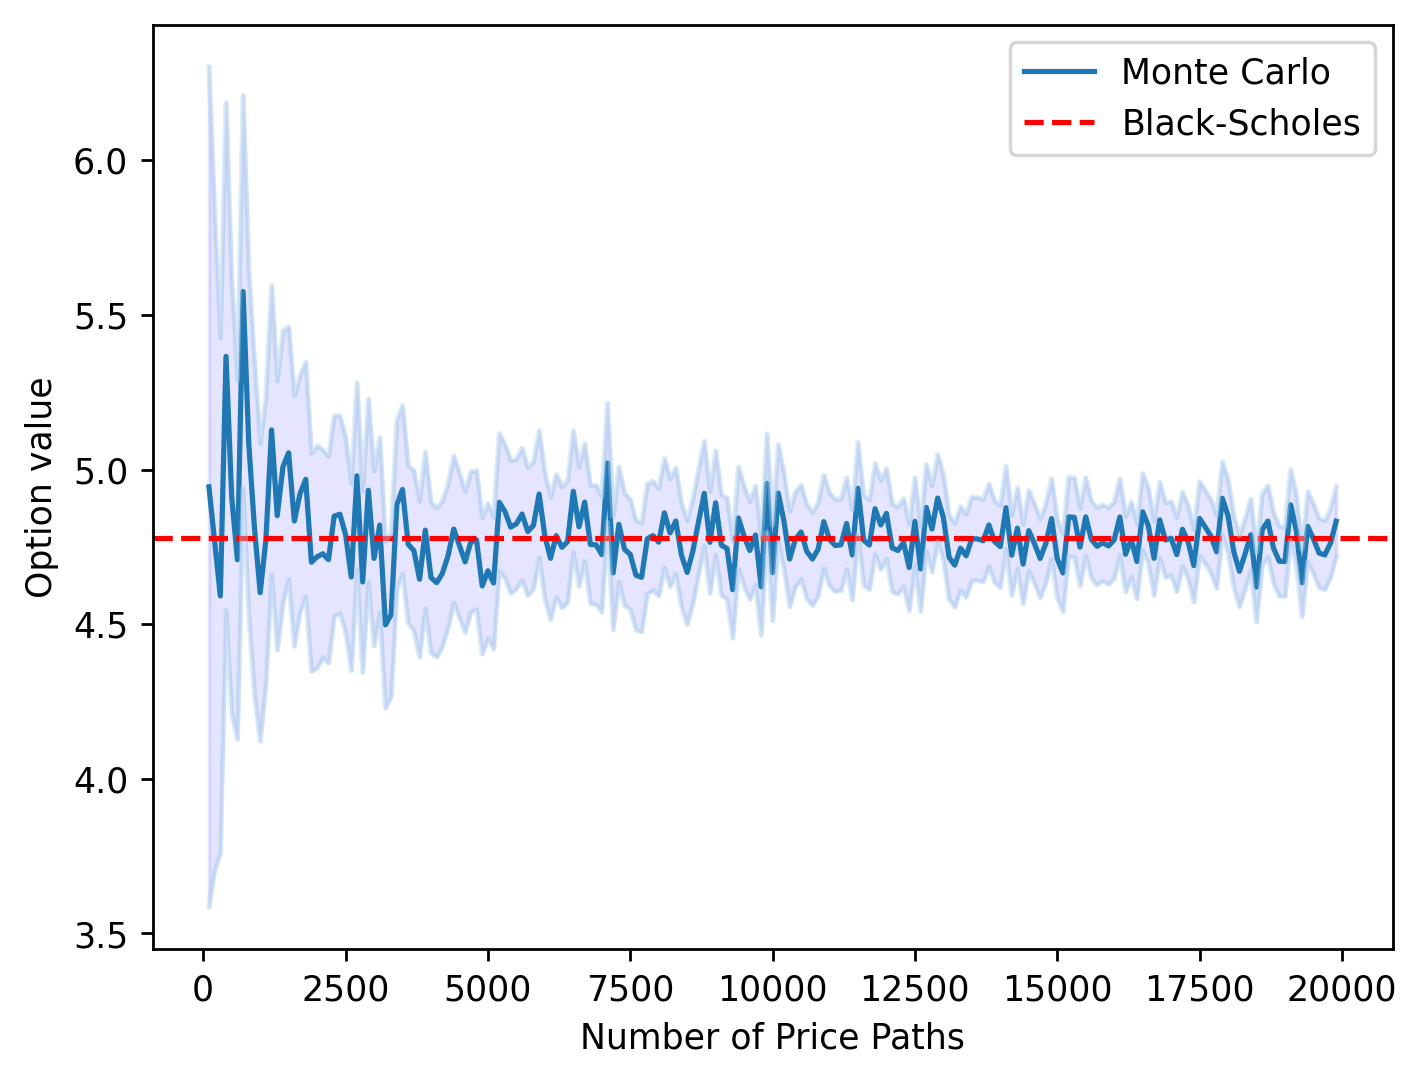

In [88]:
plt.figure(dpi=250)
plt.plot(m, option_values, label='Monte Carlo')
plt.axhline(option_BS, linestyle = "--", color = "red", label="Black-Scholes")
plt.plot(m, upper,color = "lightblue", alpha=0.4)
plt.plot(m, lower, color = "lightblue", alpha=0.4)
plt.fill_between(m, upper, lower, color="b", alpha=0.1)
plt.xlabel("Number of Price Paths")
plt.ylabel("Option value")
plt.legend()
plt.savefig("1AEuropeanPutMC.png")
plt.show()

In [122]:
std_errors[24], std_errors[99], m[24], m[99], std_errors[0]

(0.17126998833965718, 0.08412683550155478, 2500, 10000, 0.7357710166141685)

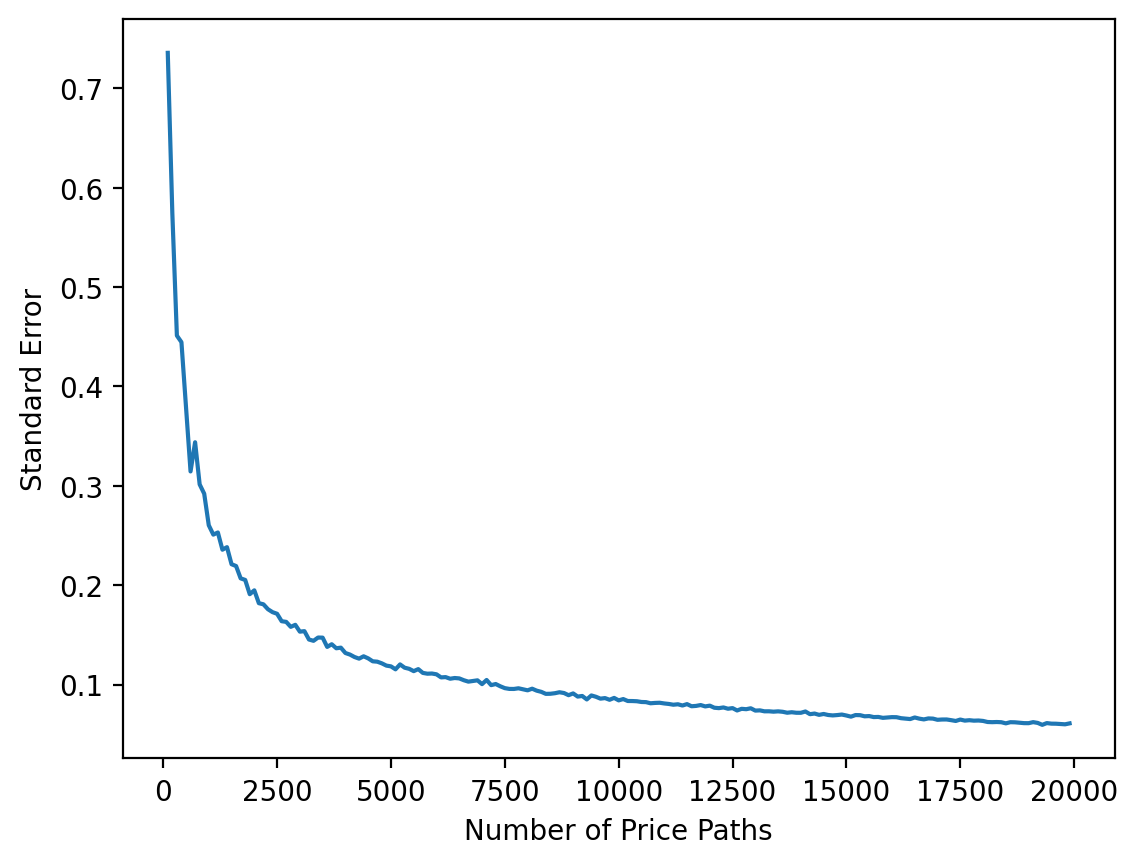

In [123]:
plt.figure(dpi=200)
plt.plot(m, std_errors)
plt.xlabel("Number of Price Paths")
plt.ylabel("Standard Error")
plt.savefig("1AStandardError.png")
plt.show()

In [10]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100 
delta_t = 1/252
N = int(T/delta_t)
m = np.arange(100, 20000, 100)
# Monte Carlo Simulation for option pricing for volatality = 0.5
sigma = 0.5
option_values2= []
std_errors2 = []
lower2 = []
upper2 = []
for M in tqdm(m):
    option_value, sd_error , ml, mu   = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    option_values2.append(option_value)
    std_errors2.append(sd_error)
    lower2.append(ml)
    upper2.append(mu)

100%|██████████| 199/199 [00:05<00:00, 36.21it/s]


In [11]:
# Option price from black scholes for volatality = 0.5
option_BS2, _ = blackScholes(S0, K, 0, T, r, sigma)

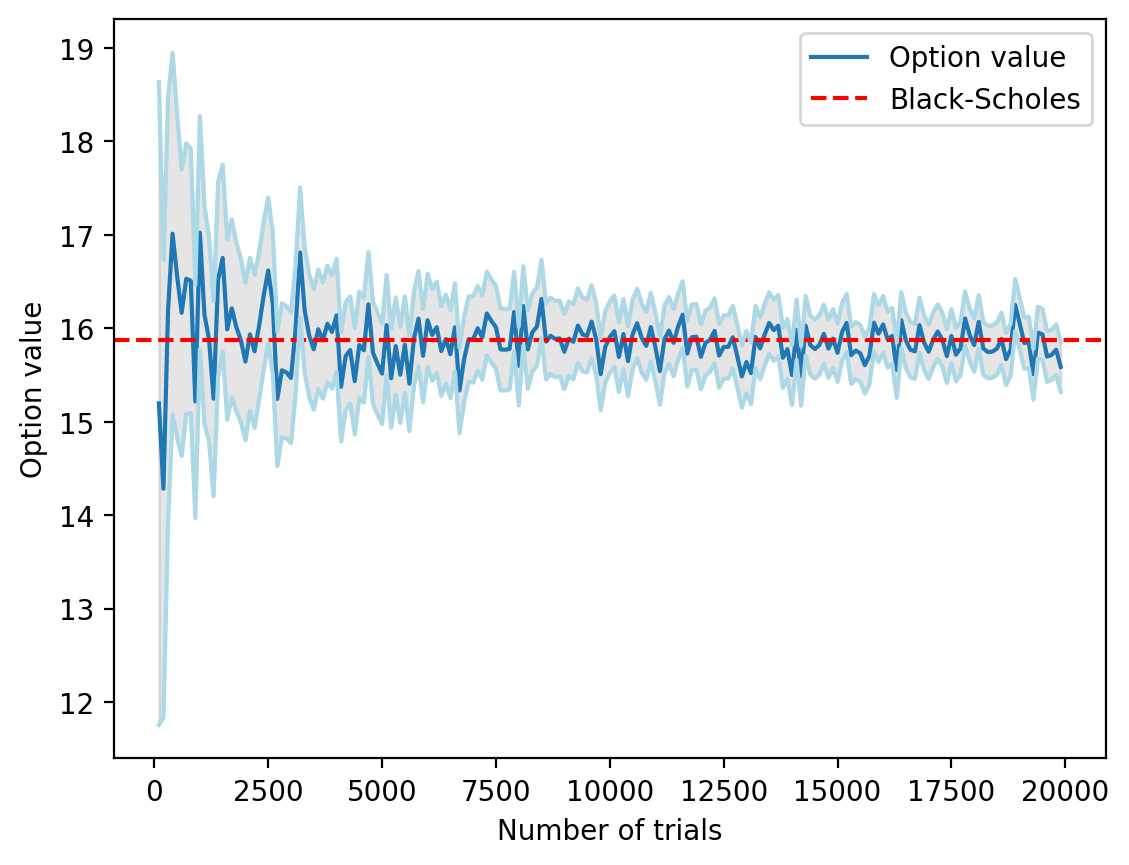

In [12]:
# Plot for option pricing for volatality = 0.5 using Monte Carlo
plt.figure(dpi=200)
plt.plot(m, option_values2, label='Option value')
plt.axhline(option_BS2, linestyle = "--", color = "red", label="Black-Scholes")
plt.plot(m, upper2, color = "lightblue")
plt.plot(m, lower2, color = "lightblue")
plt.fill_between(m, upper2, lower2, color="k", alpha=0.1)
plt.xlabel("Number of Price Paths")
plt.ylabel("Option value")
plt.legend()
plt.show()

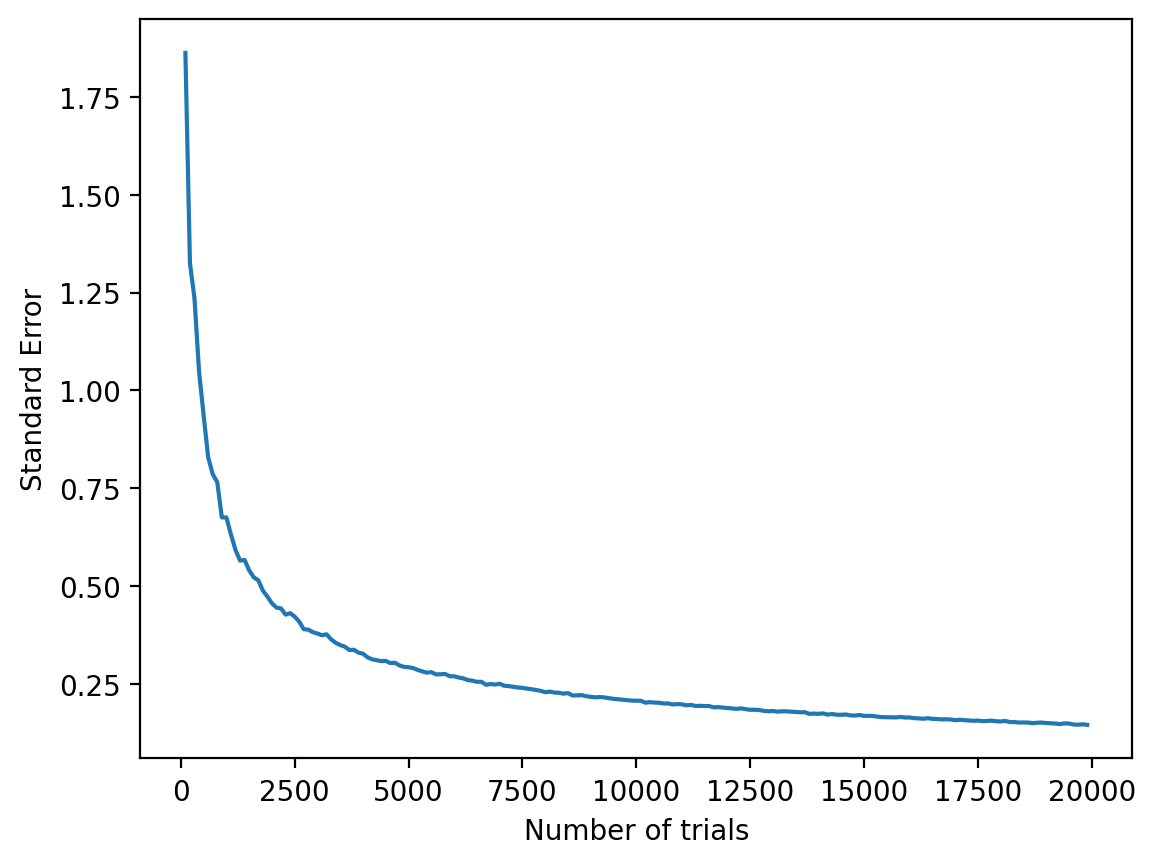

In [13]:
# Plot for standard error for volatality = 0.5 using Monte Carlo
plt.figure(dpi=200)
plt.plot(m, std_errors2)
plt.xlabel("Number of trials")
plt.ylabel("Standard Error")
plt.show()

##### Varying strike Price

In [112]:
# Parameters
K = np.arange(80, 120, 0.5)
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
M = 10000
N = int(T/delta_t)

# Monte Carlo Simulation for option pricing for different strike prices
option_values3 = []
std_errors3 = []
lower3 = []
upper3 = []
option_BS3 = []

for k in tqdm(K):
    option_value, sd_error , ml, mu  = priceOption(S0, r, delta_t, N, sigma, k, M, "put")
    option_B3, _ = blackScholes(S0, k, 0, T, r, sigma, option_type="put")
    option_BS3.append(option_B3)
    option_values3.append(option_value)
    std_errors3.append(sd_error)
    lower3.append(ml)
    upper3.append(mu)

100%|██████████| 80/80 [00:02<00:00, 35.65it/s]


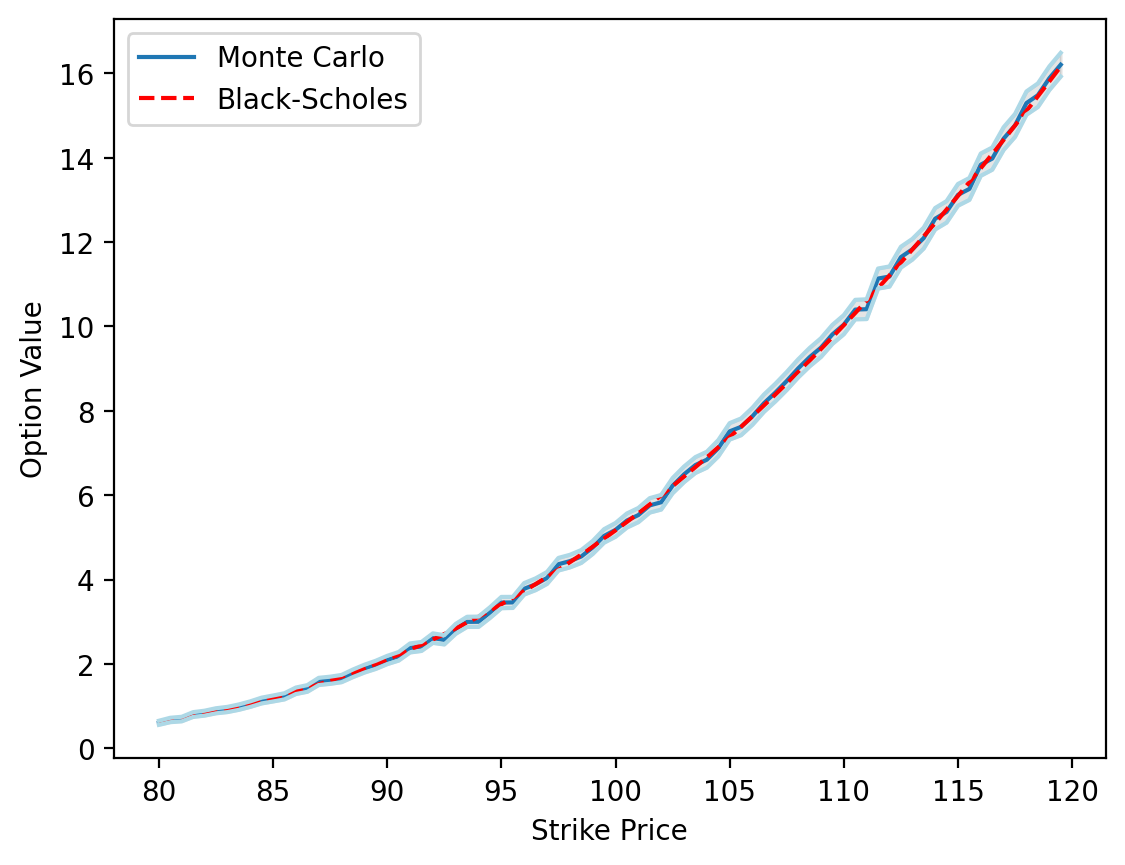

In [113]:
##Plotting the option values
plt.figure(dpi=200)
plt.plot(K, option_values3, label= "Monte Carlo")
plt.plot(K, option_BS3, linestyle = "--", color = "red", label="Black-Scholes")
plt.plot(K, upper3, color = "lightblue")
plt.plot(K, lower3, color = "lightblue")
plt.fill_between(K, upper3, lower3, color="k", alpha=0.1)
plt.xlabel("Strike Price")
plt.ylabel("Option Value")
plt.legend()
plt.savefig("1A_strikePrice.png")

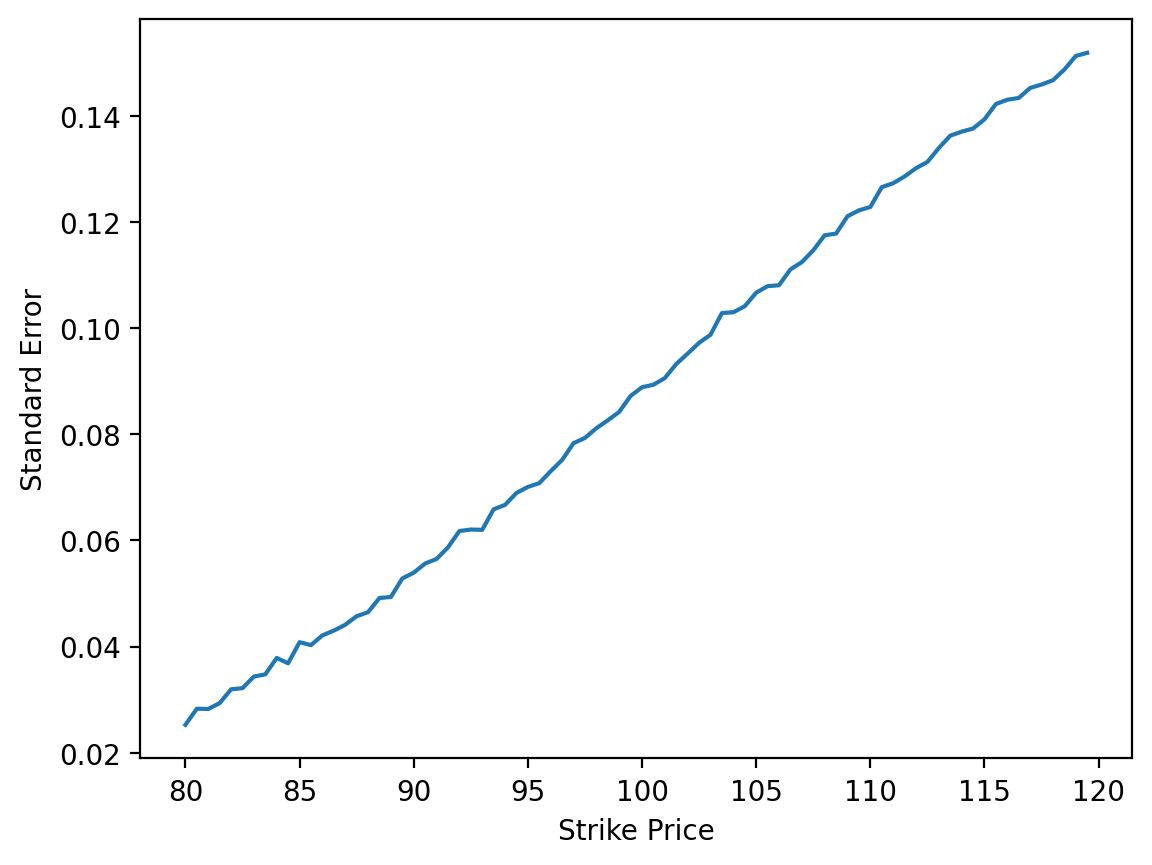

In [16]:
plt.figure(dpi=200)
plt.plot(K, std_errors3)
plt.xlabel("Strike Price")
plt.ylabel("Standard Error")
plt.show()

### Varying volatality in Monte Carlo 

In [107]:
# Parameters
vols = np.arange(0.1, 1.0, 0.01)
K = 99
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
M = 10000
N = int(T/delta_t)
CI_lower_vol = []
CI_upper_vol = []
std_errors_vol = []
option_BS_vol = []
option_values = []
for vol in tqdm(vols):
    option_value, std_error, ml, mu = priceOption(S0, r, delta_t, N, vol, K, M, "put")
    option_bsVol, _ = blackScholes(S0, K, 0, T, r, vol, option_type="put")
    option_BS_vol.append(option_bsVol)
    option_values.append(option_value)
    std_errors_vol.append(std_error)
    CI_lower_vol.append(ml)
    CI_upper_vol.append(mu)

100%|██████████| 90/90 [00:02<00:00, 35.26it/s]


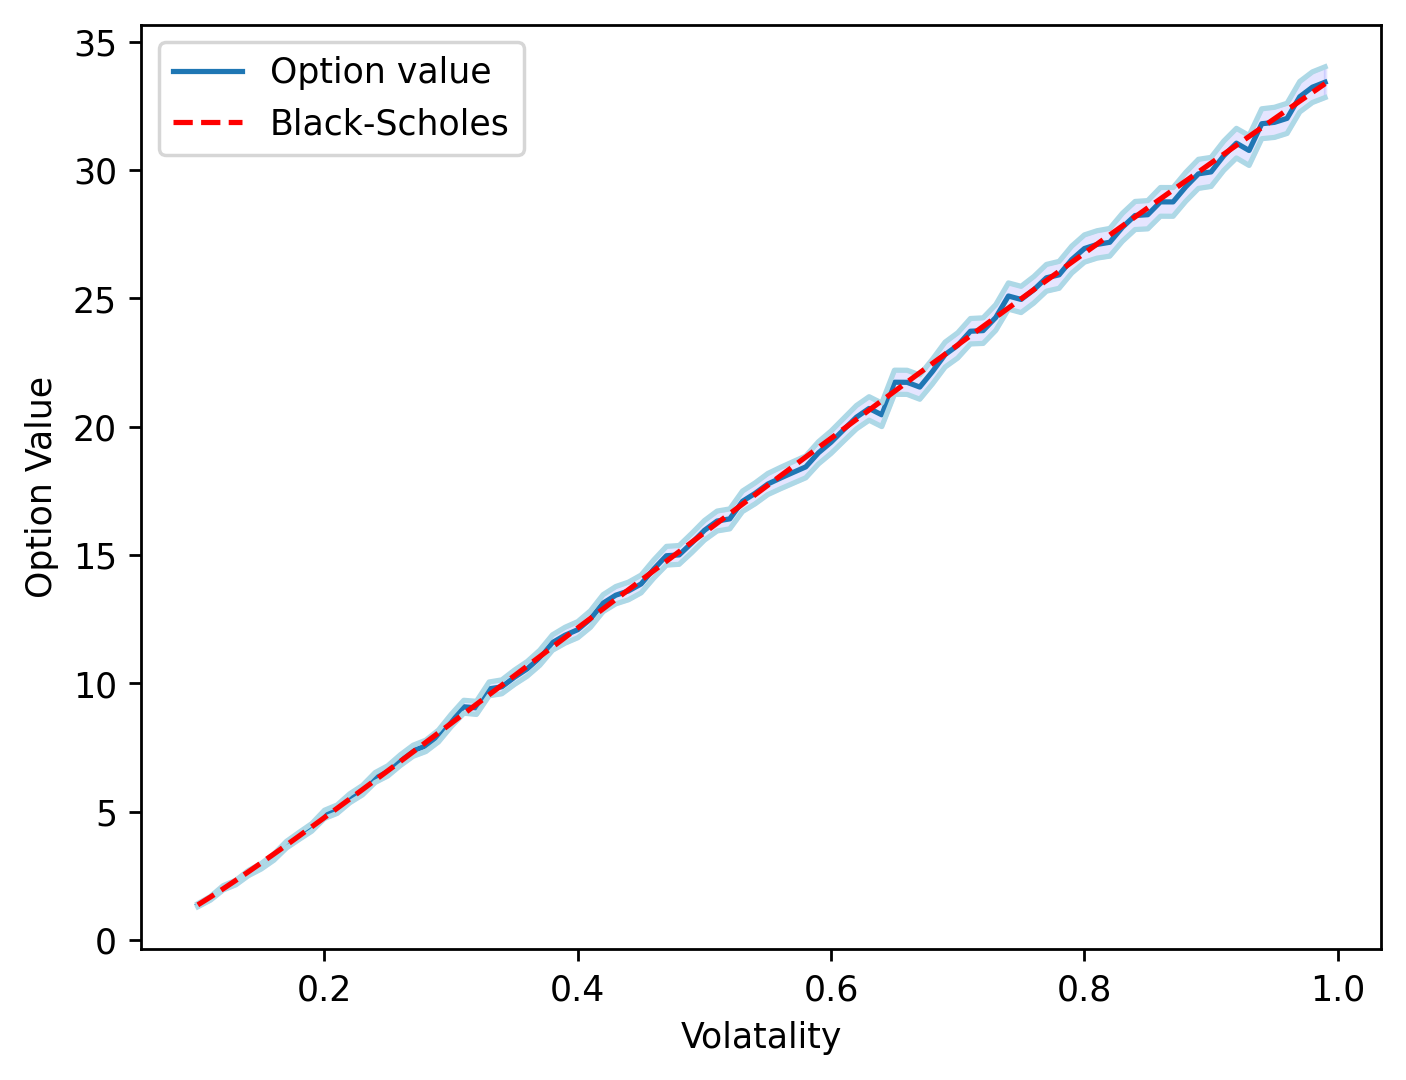

In [114]:
##Plotting the option values
plt.figure(dpi=250)
plt.plot(vols, option_values, label='Option value')
plt.plot(vols, CI_upper_vol, color = "lightblue")
plt.plot(vols, CI_lower_vol, color = "lightblue")
plt.fill_between(vols, CI_upper_vol, CI_lower_vol, color="blue", alpha=0.1)
plt.plot(vols, option_BS_vol, linestyle = "--", color = "red", label="Black-Scholes")
plt.xlabel("Volatality")
plt.ylabel("Option Value")
plt.legend()
plt.savefig("1A_volatility.png")

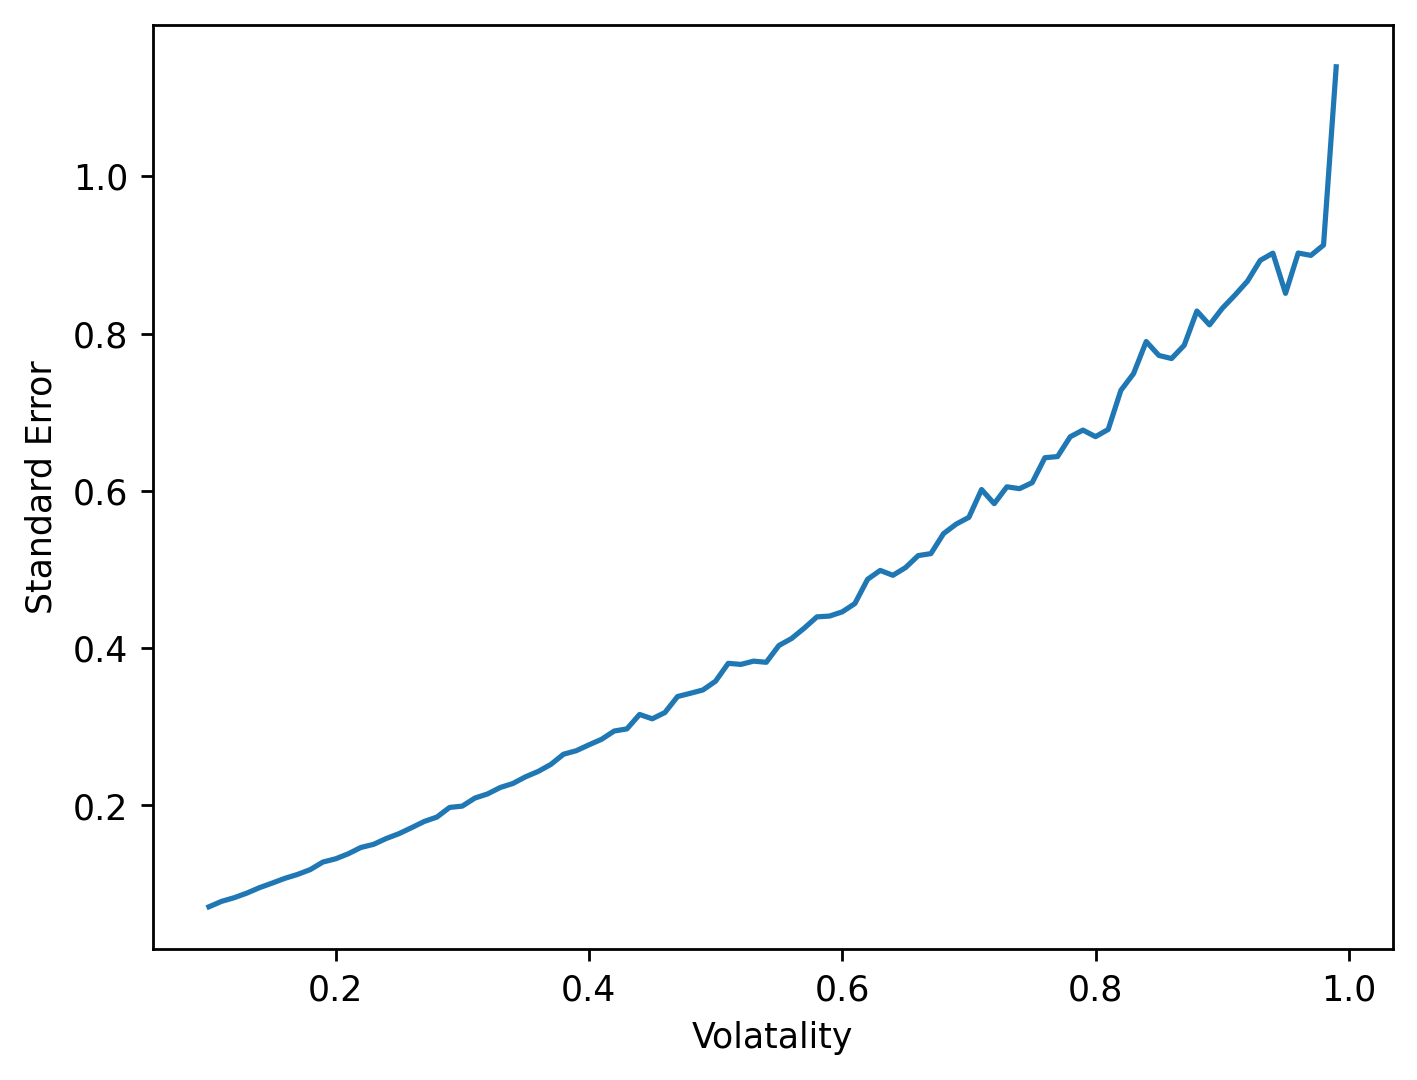

In [19]:
plt.figure(dpi=250)
plt.plot(vols, std_errors_vol)
plt.xlabel("Volatality")
plt.ylabel("Standard Error")    
plt.show()  

### Part I - B

##### Milstein - Heston Model

In [20]:
@njit
def confidence_interval2(data):
        """
        Function to calculate confidence interval

        Args:
            data: Data for which confidence interval is to be calculated

        Returns:
                m-h, m+h : Lower and upper bounds of the confidence interval
        """
        a = data.shape[0]
        m, sd = np.mean(data), np.std(data)
        h = 1.96*sd/np.sqrt(a)
        return m - h, m + h

In [21]:
## Milstein Variance Process
@njit
def m_Heston(k, dt, vol_of_vol, theta, corr, r, S0, Barrirer, K):
    prev_v = 0
    prev_S = S0
    Zv = np.random.normal()
    Z2 = np.random.normal()
    Zs = corr * Zv + np.sqrt(1 - corr**2) * Z2
    #variance = [prev_v]
    #assetPrice = [prev_S]
    
    for _ in np.arange(dt, 1., dt):
        vplus = np.maximum(0, prev_v)
        next_v = prev_v + k * (theta - vplus) * dt + vol_of_vol * np.sqrt(vplus * dt) * Zv + vol_of_vol ** 2 * dt * (Zv**2-1)/4
        next_S = prev_S + r * prev_S * dt + np.sqrt(vplus * dt) * Zs * prev_S + vplus * prev_S* dt * (Zs ** 2 - 1)/2
        prev_v = next_v
        if next_S >= Barrirer:
            return 0
        #variance.append(prev_v)
        #assetPrice.append(next_S)
    payOff = max(0, next_S - K)
    
    return payOff
        

In [22]:
## Milstein Variance Process

def m_HestonEuler(delta_t, vol_of_vol, r, S0, Barrirer, K):
    
    prev_S = S0
    stock_prices = np.zeros(N)
    stock_prices[0] = prev_S
    for i in range(1, N):
        Zm = np.random.normal()
        next_S = prev_S * ( 1 + r * delta_t + vol_of_vol * np.sqrt(delta_t) * Zm )
        prev_S = next_S
        stock_prices[i] = next_S
        if next_S > Barrirer:
            return 0
    payOff = np.maximum(0, next_S - K)
    
    return payOff

In [23]:
@njit
def approximateOptionPrice_MH(k, dt, vol_of_vol, theta, corr, r, S0, B, K):
    
    payoffs_MH = np.zeros(10000)
    for i in range(10000):
        payoff = m_Heston(k, dt, vol_of_vol, theta, corr, r, S0, B, K)
        payoffs_MH[i] = payoff 
    option_approx = np.mean(payoffs_MH) * np.exp(-r* T)
    confidence_interval = confidence_interval2(payoffs_MH * np.exp(-r*T))
    
    return option_approx, confidence_interval


## Analysis

In [24]:
#### Initial Parameters
r = 0.05            # Risk free interest rate
theta = 0.04        # Long term variance
k = 2               # Mean reversion speed
vol_of_vol = 0.1    # Volatility of volatility
corr = - 0.7        # Correlation between the asset price and the variance
dt = 1/252          # Time step   
S0 =100             # Initial stock price
T = 1.0             # Maturity
K = 99              # Strike price
Barrier = np.arange(90, 120, 0.5)   # Barrier range

#### Variation in Barrier

In [25]:
## Approximating the option price using Milstein Variance Process with Varying Barrier
option_prices_B = []
ci_lower_B = []
ci_upper_B = []
for B in tqdm(Barrier):
    option_approx, CI = approximateOptionPrice_MH(k, dt, vol_of_vol, theta, corr, r, S0, B, K)
    option_prices_B.append(option_approx) 
    ci_lower_B.append(CI[0])
    ci_upper_B.append(CI[1])   

100%|██████████| 60/60 [00:01<00:00, 47.72it/s]


In [26]:
Option_BS = blackScholes(S0, K, 0, T, 0.05, 0.02, option_type="call")
Option_BS

(5.829022077168432, 0.9987045444955182)

Text(0, 0.5, 'Option Value')

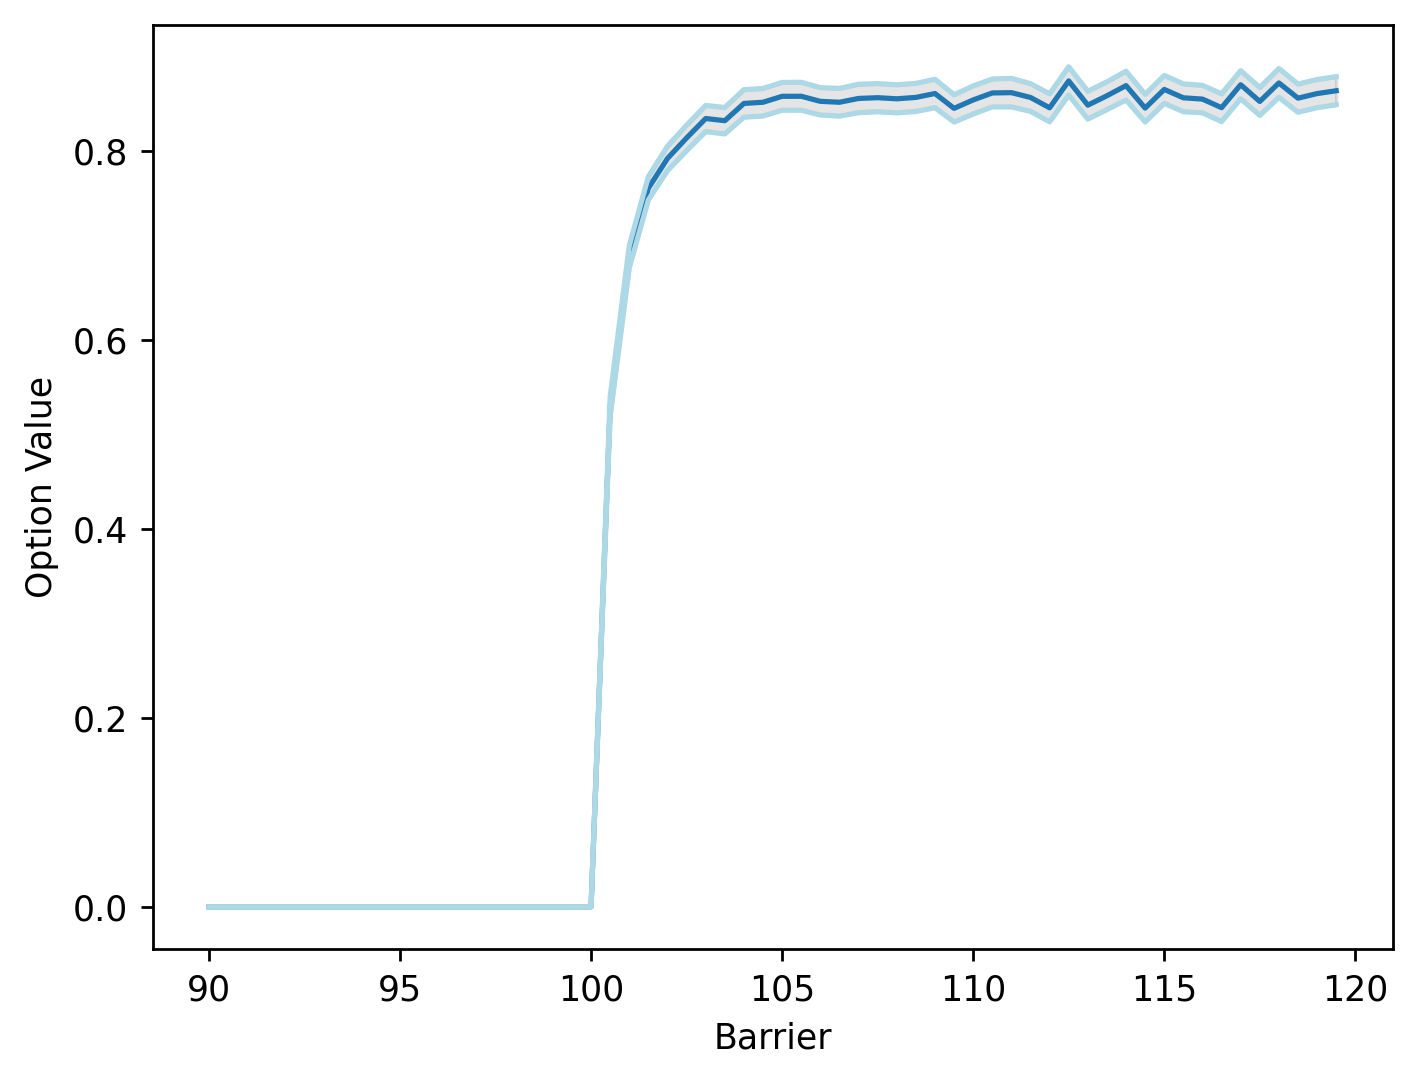

In [27]:
# Plotting the option prices for different barriers with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(Barrier, option_prices_B)
plt.plot(Barrier, ci_upper_B, color = "lightblue")
plt.plot(Barrier, ci_lower_B, color = "lightblue")
plt.fill_between(Barrier, ci_upper_B, ci_lower_B, color="k", alpha=0.1)
plt.xlabel("Barrier")
plt.ylabel("Option Value")


#### Variation in Correlation

In [28]:
#### Initial Parameters
r = 0.05            # risk free rate
theta = 0.04        # long term variance
k = 2               # mean reversion
vol_of_vol = 0.1    # volatility of volatility
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price            
B = 120             # barrier         
#Correlation
corr = np.arange(-1, 1.1, 0.1)

In [29]:
option_prices_corr = []
ci_lower_volB = []
ci_upper_volB = []
for Correlation in tqdm(corr):
    option_approx, CI_volB = approximateOptionPrice_MH(k, dt, vol_of_vol, theta, Correlation, r, S0, B, K)
    option_prices_corr.append(option_approx)
    ci_upper_volB.append(CI_volB[1])
    ci_lower_volB.append(CI_volB[0])
    

100%|██████████| 21/21 [00:00<00:00, 32.65it/s]


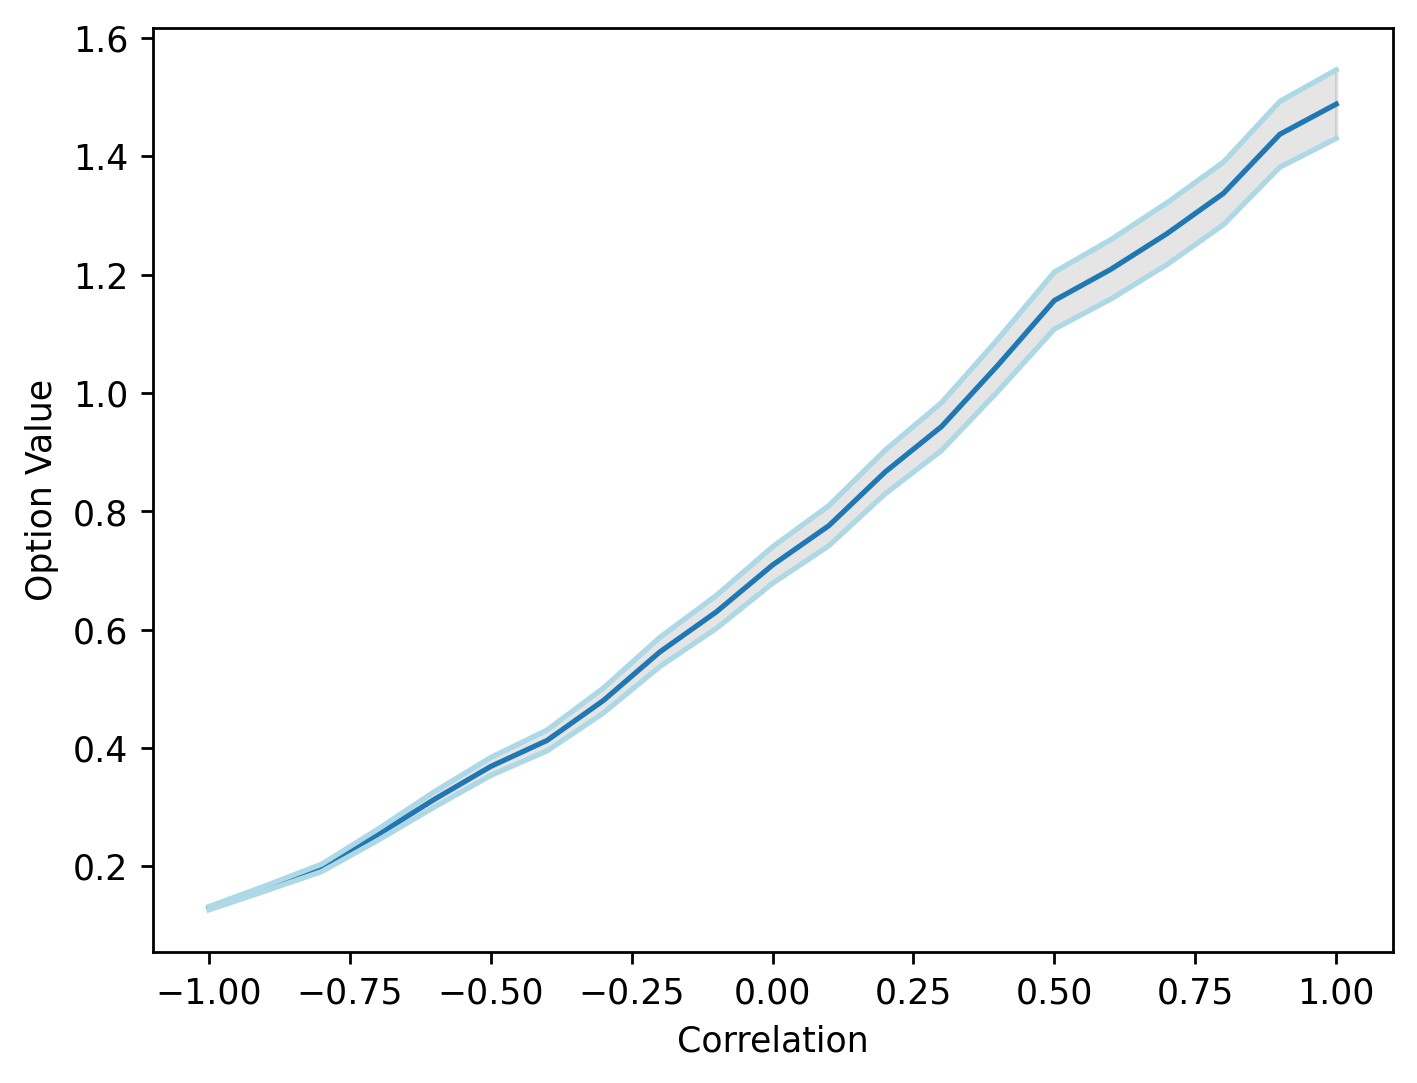

In [30]:
# Plotting the option prices for different correlation with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(corr, option_prices_corr)
plt.plot(corr, ci_lower_volB, color = "lightblue")
plt.plot(corr, ci_upper_volB, color = "lightblue")
plt.fill_between(corr, ci_upper_volB, ci_lower_volB, color="k", alpha=0.1)
plt.xlabel("Correlation")
plt.ylabel("Option Value")
plt.show()

#### Variation in Vol of Vol

In [31]:
#### Initial Parameters
r = 0.05            # risk free rate
theta = 0.04        # long term variance
k = 2               # mean reversion
corr = - 0.7        # correlation
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price            
B = 120             # barrier         
#Correlation
vol_of_vol = np.arange(0, 1, 0.025)

In [32]:
# Approximating the option price using Milstein Variance Process with Varying Volatility of Volatility
option_prices_vol_of_vol = []
ci_lower_volOfvol = []
ci_upper_volOfvol = []
for volOfvol in tqdm(vol_of_vol):
    option_approx, CI_volOfvol = approximateOptionPrice_MH(k, dt, volOfvol, theta, corr, r, S0, B, K)
    option_prices_vol_of_vol.append(option_approx)
    ci_lower_volOfvol.append(CI_volOfvol[0])
    ci_upper_volOfvol.append(CI_volOfvol[1])
    

100%|██████████| 40/40 [00:00<00:00, 40.55it/s]


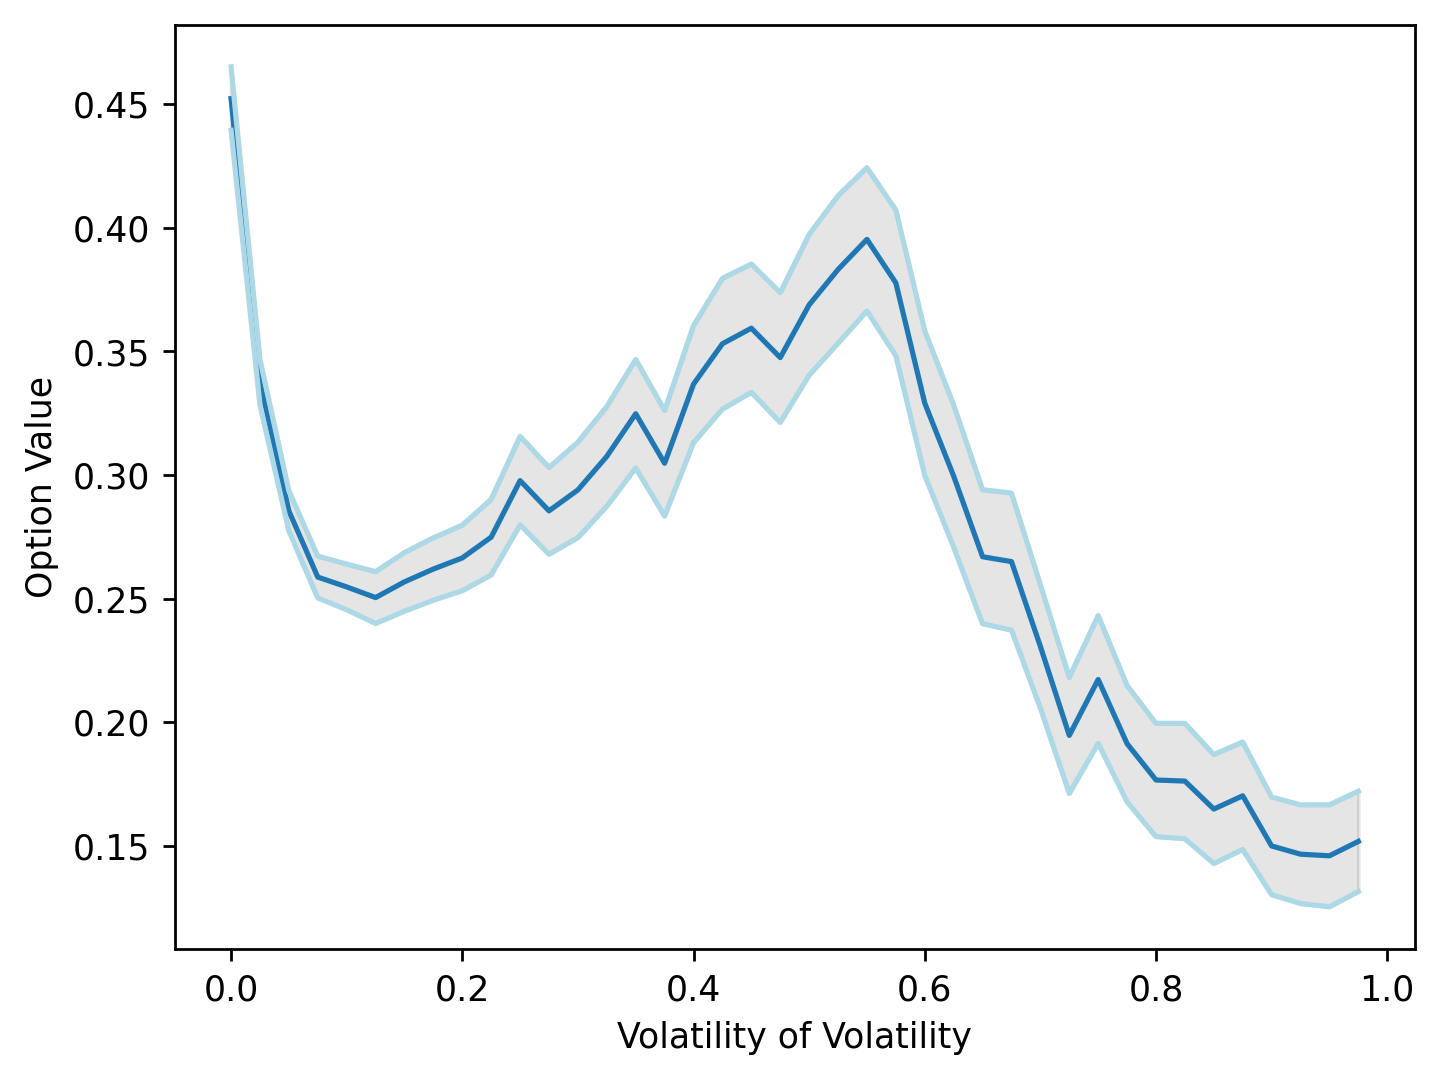

In [33]:
# Plotting the option prices for different volatility of volatility with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(vol_of_vol, option_prices_vol_of_vol)
plt.plot(vol_of_vol, ci_lower_volOfvol, color = "lightblue")
plt.plot(vol_of_vol, ci_upper_volOfvol, color = "lightblue")
plt.fill_between(vol_of_vol, ci_upper_volOfvol, ci_lower_volOfvol, color="k", alpha=0.1)
plt.xlabel("Volatility of Volatility")
plt.ylabel("Option Value")
plt.show()

##### Variation in Mean Reversion

In [34]:
#### Initial Parameters
r = 0.05            # risk free rate
theta = 0.04        # long term variance
vol_of_vol = 0.1      # volatility of volatility
corr = - 0.7        # correlation
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price            
B = 120             # barrier         
# Mean Reversion
k = np.arange(0, 50, 0.5)

In [35]:
# Approximating the option price using Milstein Variance Process with Varying Mean Reversion
option_prices_k = []
ci_lower_k = []
ci_upper_k = []
for k_ in tqdm(k):
    option_approx, CI_k = approximateOptionPrice_MH(k_, dt, vol_of_vol, theta, corr, r, S0, B, K)
    option_prices_k.append(option_approx)
    ci_lower_k.append(CI_k[0])
    ci_upper_k.append(CI_k[1])

100%|██████████| 100/100 [00:02<00:00, 39.45it/s]


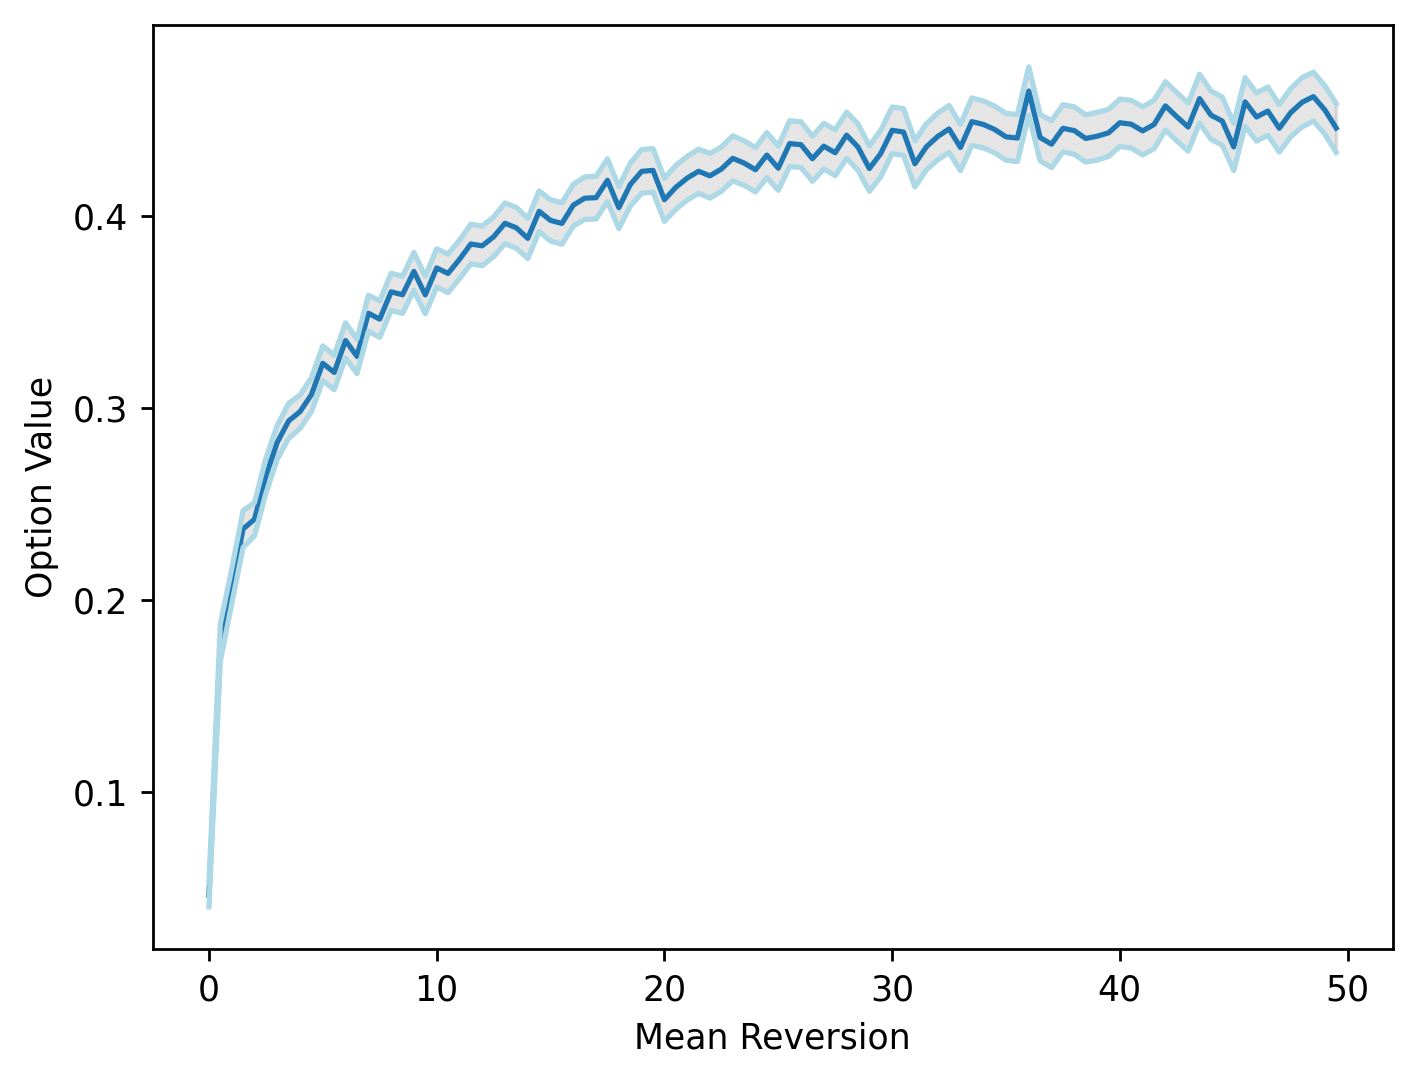

In [36]:
# Plotting the option prices for different mean reversion with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(k, option_prices_k)
plt.plot(k, ci_lower_k, color = "lightblue")
plt.plot(k, ci_upper_k, color = "lightblue")
plt.fill_between(k, ci_upper_k, ci_lower_k, color="k", alpha=0.1)
plt.xlabel("Mean Reversion")
plt.ylabel("Option Value")
plt.show()

## Estimation of Sensitivities in MC

#### Bump and Revalue Method for Delta

In [37]:
@njit
def payOffs(S0, r, delta_t, N, sigma, K, M, option_type = "put" , seed_value = None):
    """
    Function calculate the payoffs for the option for multiple Paths
    Args:
        S0 : Stock price at time 0
        r : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatality of the stock
        K : Strike price
        M : Number of simulations
        option_type : Type of option (call/put)
    Returns:
        price_option : Price of the option
        std_error : Standard error
        ml : Lower bound of the confidence interval 
        mu : Upper bound of the confidence interval
    """
    
    np.random.seed(seed_value)
    pay_offs = np.zeros(M)
    
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = max(stock_price_N - K, 0)
        else:
            pay_off = max(K - stock_price_N, 0)
        pay_offs[i] = pay_off
    return pay_offs
    

In [38]:
#### Initial Parameters
r = 0.05            # risk free rate
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price 
N = 252
M = 20000
volatilities = np.arange(0.01, 1, 0.01)
deltas_sameseed = []
lower_delta = []
upper_delta = []
delta_B = []
delta_DiffSeed = []
lower_diffSeed = []
upper_diffSeed = []
for sigma in tqdm(volatilities):
    pay_off = payOffs(S0, r, dt, N, sigma, K, M, seed_value=1)
    pay_off_bump = payOffs(S0 + 1, r, dt, N, sigma, K, M, seed_value=1)
    pay_off_bump2 = payOffs(S0 + 1, r, dt, N, sigma, K, M, seed_value=2)
    delta = np.mean(((pay_off_bump - pay_off)/1)*np.exp(-r*T))
    delta_diffSeed = (np.mean(((pay_off_bump2 - pay_off)/1)*np.exp(-r*T)))
    delta_B.append(blackScholes(S0, K, 0, T, r, sigma)[1])
    CI_diffSeed = confidence_interval2(((pay_off_bump2 - pay_off)/1)*np.exp(-r*T))
    CI_lower_delta, CI_upper_delta  = confidence_interval2(((pay_off_bump - pay_off)/1)*np.exp(-r*T))
    deltas_sameseed.append(delta)
    delta_DiffSeed.append(delta_diffSeed)
    lower_delta.append(CI_lower_delta)
    upper_delta.append(CI_upper_delta)
    lower_diffSeed.append(CI_diffSeed[0])
    upper_diffSeed.append(CI_diffSeed[1])


100%|██████████| 99/99 [00:16<00:00,  5.83it/s]


Text(0, 0.5, 'Delta')

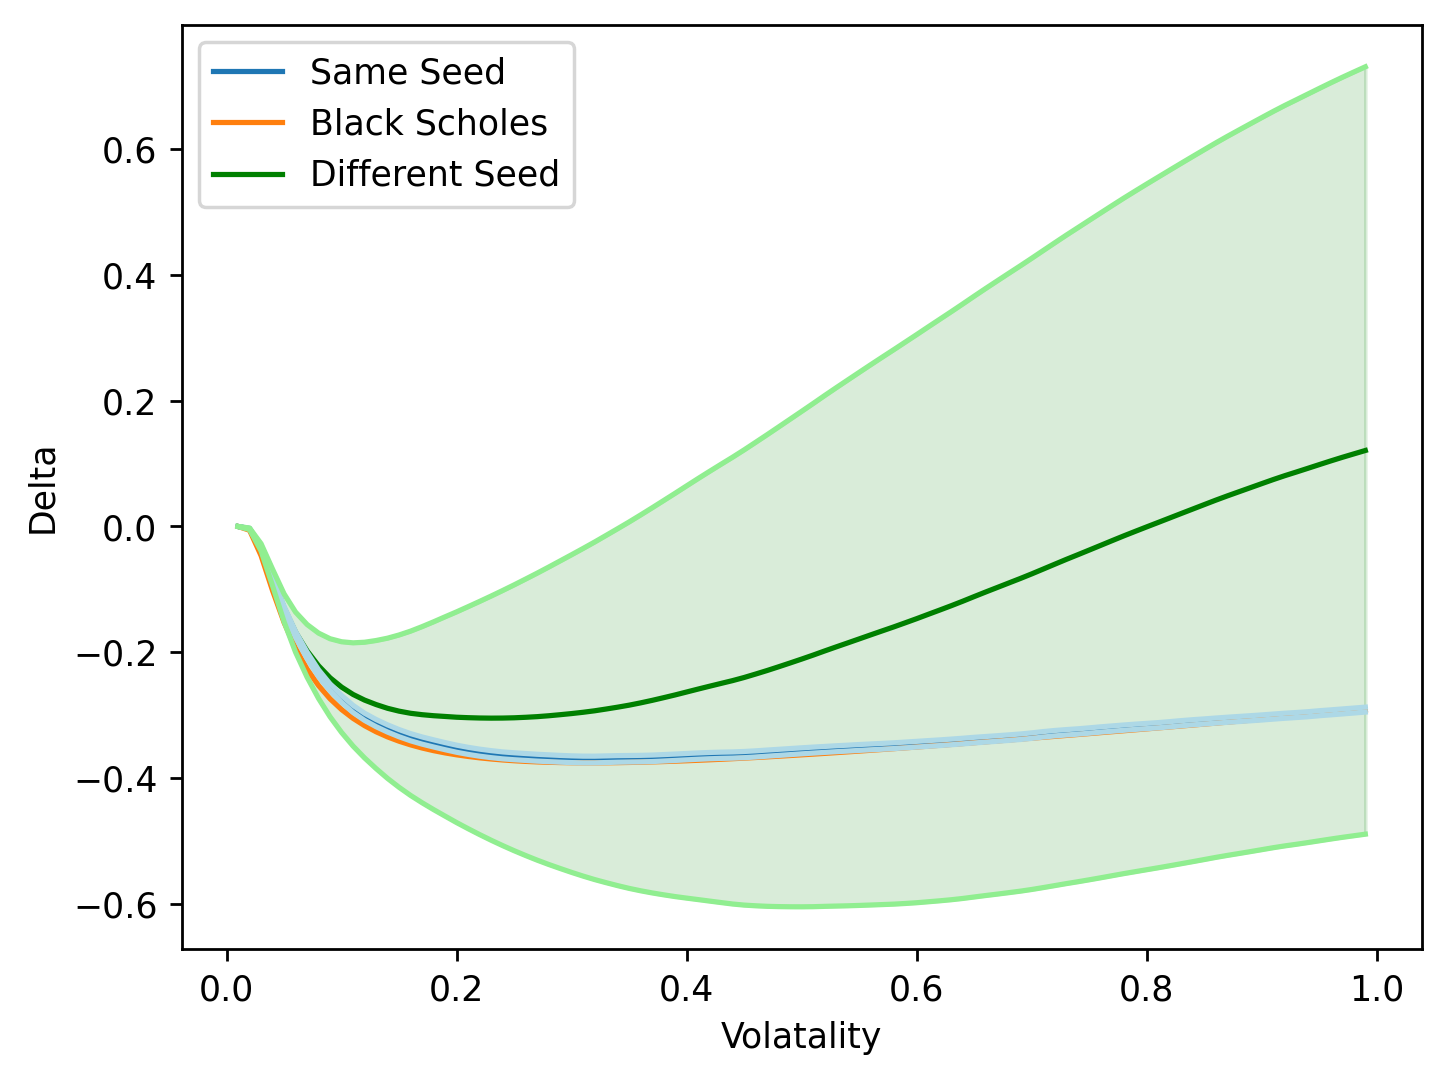

In [39]:
plt.figure(dpi=250)
plt.plot(volatilities, deltas_sameseed, label="Same Seed")
plt.plot(volatilities, delta_B, label="Black Scholes")
plt.plot(volatilities, delta_DiffSeed, label="Different Seed", color = "green")
plt.plot(volatilities, upper_delta, color = "lightblue")
plt.plot(volatilities, lower_delta, color = "lightblue")
plt.plot(volatilities, upper_diffSeed, color = "lightgreen")
plt.plot(volatilities, lower_diffSeed, color = "lightgreen")
plt.fill_between(volatilities, upper_diffSeed, lower_diffSeed, color="green", alpha=0.15)
plt.fill_between(volatilities, upper_delta, lower_delta, color="lightblue", alpha=0.1)
plt.legend()
plt.xlabel("Volatality")
plt.ylabel("Delta")


#### Digital Option

In [40]:
def OptionPrice_Digital(S0, r, delta_t, N, sigma, K, M, option_type = "call" , seed_value = 2):
    """
    Function to price the option using Monte Carlo simulation for Digital Option

    Args:
        S0 : Stock price at time 0
        r : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatality of the stock
        K : Strike price
        M : Number of simulations
        option_type (str, optional): Type of Option. Defaults to "call".
        seed_value (int, optional): Seed value for random number generation.Defaults to 2.

    Returns:
        price_option : Price of the option at current time
        std_error : Standard error
        ml : Lower bound of the confidence interval
        mu : Upper bound of the confidence interval
    """
    np.random.seed(seed_value)
    pay_offs = np.zeros(M)
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = 1 * (stock_price_N > K)
        else:
            pay_off = 1 * (stock_price_N < K)
        pay_offs[i] = pay_off
    ml, mu = confidence_interval(pay_offs * np.exp(-r*T))
    price_option = np.exp(-r*T) * np.mean(pay_offs)
    std_error = np.std(pay_offs) / np.sqrt(M)
    
    return price_option, std_error, ml, mu

In [41]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
m = np.arange(100, 20000, 100)

option_values_digi = []
std_errors_digi = []
lower_digi = []
upper_digi = []
# Monte Carlo Simulation for Digital Option pricing
for M in tqdm(m):
    option_value, sd_error , ml, mu = OptionPrice_Digital(S0, r, delta_t, N, sigma, K, M,"put")
    option_values_digi.append(option_value)
    std_errors_digi.append(sd_error)
    lower_digi.append(ml)
    upper_digi.append(mu)

100%|██████████| 199/199 [00:07<00:00, 25.90it/s]


In [42]:
def analyticlDigital(S0, r, T, sigma, K, option_type = "call"):
    """
    Function to calculate the price of the Digital option using Black Scholes model

    Args:
        S0 : Current stock price
        r : Risk free interest rate
        T : Maturity time
        sigma : Volatality of the stock
        K : Strike price
        option_type : Type of option (call/put)

    Returns:
        Option_price : Price of the option at current time
    """
    d2 = (np.log(S0/K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    if option_type == "call":
        return np.exp(-r * T) * norm.cdf(d2)
    else:
        return np.exp(-r * T) * norm.cdf(-d2)

In [43]:
analyticalPrice_Digital = analyticlDigital(S0, r, T, sigma, K, option_type = "put")
print("Analytical Price for Digital Option: ", analyticalPrice_Digital)

Analytical Price for Digital Option:  0.3778325038222435


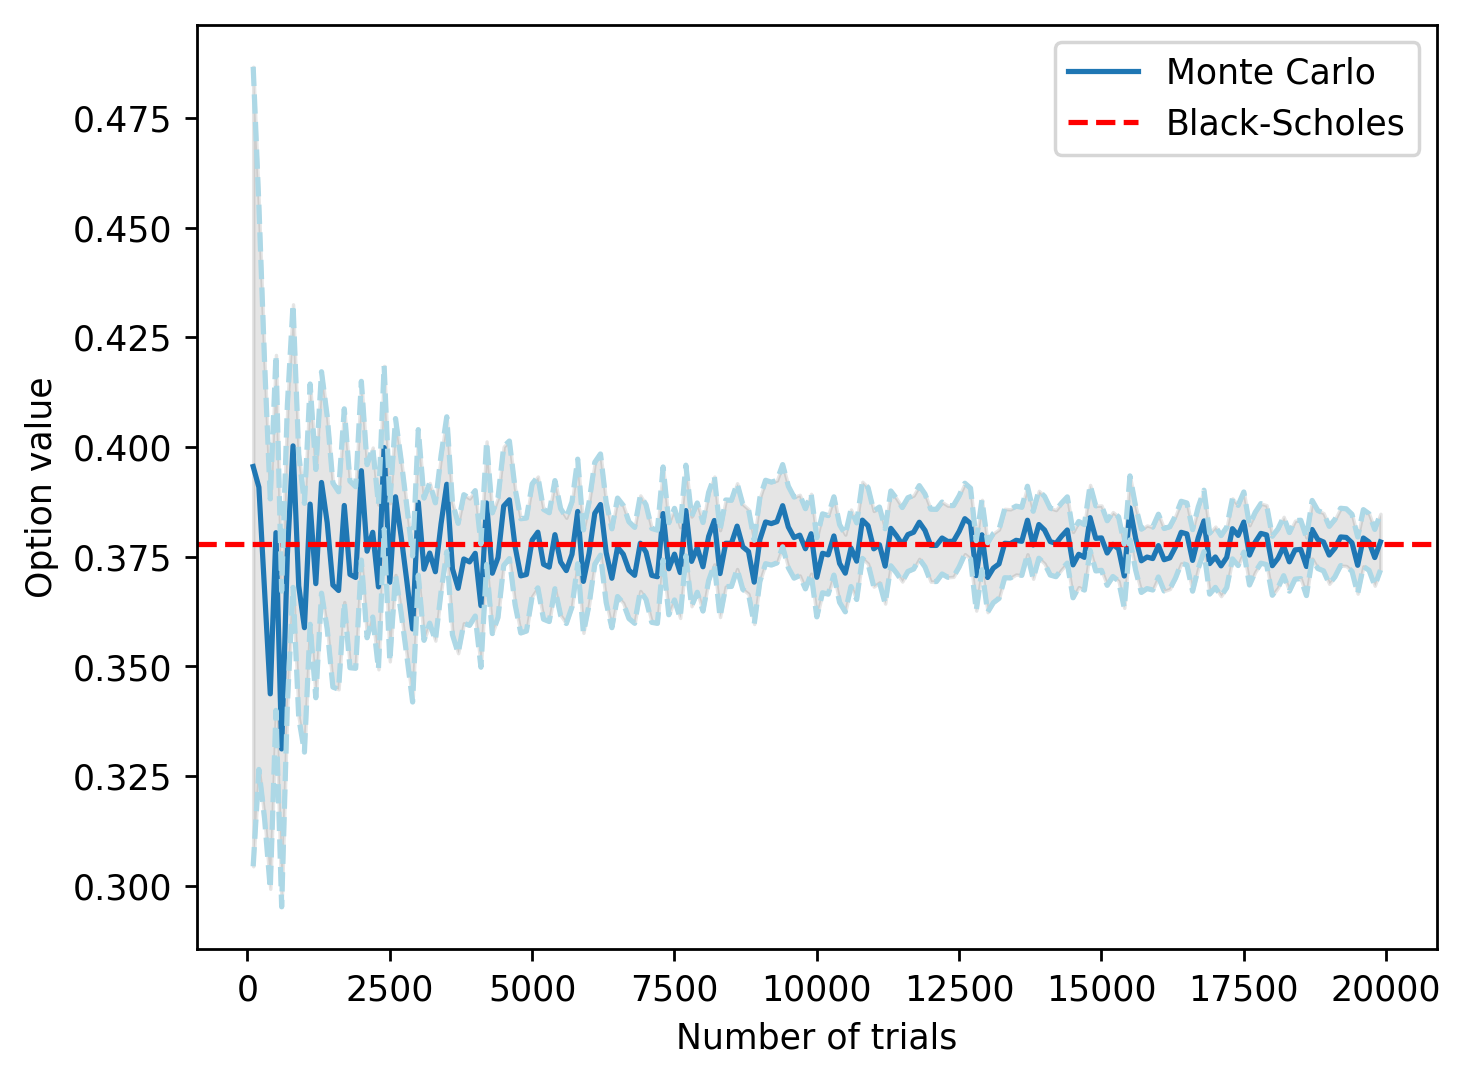

In [44]:
# Plot for Digital Option pricing using Monte Carlo
plt.figure(dpi = 250)
plt.plot(m, option_values_digi, label='Monte Carlo')
plt.axhline(analyticalPrice_Digital, linestyle = "--", color = "red", label="Black-Scholes")
plt.plot(m, upper_digi, "lightblue")
plt.plot(m, lower_digi, "lightblue")
plt.fill_between(m,upper_digi, lower_digi, color="k", alpha=0.1)
plt.xlabel("Number of trials")
plt.ylabel("Option value")
plt.legend()
plt.show()

#### Delta for digital option Using Bump and Revalue method

In [45]:
@njit
def payOffs_Digital(S0, r, delta_t, N, sigma, K, M, option_type = "put" , seed_value = None):
    """
    Function calculate the payoffs for the option for multiple Paths
    Args:
        S0 : Stock price at time 0
        r : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatality of the stock
        K : Strike price
        M : Number of simulations
        option_type : Type of option (call/put)
    Returns:
        price_option : Price of the option
        std_error : Standard error
        ml : Lower bound of the confidence interval 
        mu : Upper bound of the confidence interval
    """
    
    np.random.seed(seed_value)
    pay_offs = np.zeros(M)
    
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = 1 * (stock_price_N > K)
        else:
            pay_off = 1 * (stock_price_N < K)
        pay_offs[i] = pay_off
    return pay_offs

In [46]:
T = 1.0
K = 99
r = 0.06
S0 = 100
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
M = 10000
volatilities = np.arange(0.01, 1, 0.01)
deltas_sameseed_digi = []
lower_delta_digi = []
upper_delta_digi = []
delta_B = []
delta_DiffSeed_digi = []
lower_diffSeed_digi = []
upper_diffSeed_digi = []
for sigma in tqdm(volatilities):
    pay_off_digi = payOffs_Digital(S0, r, dt, N, sigma, K, M, "put", seed_value=146)
    pay_off_bump_digi = payOffs_Digital(S0 + 4, r, dt, N, sigma, K, M,'put', seed_value=146)
    pay_off_bump2_digi = payOffs_Digital(S0 + 4, r, dt, N, sigma, K, M, 'put', seed_value=4)
    delta_digi = np.mean(((pay_off_bump_digi - pay_off_digi)/4)*np.exp(-r*T))
    delta_diffSeed_digi = (np.mean(((pay_off_bump2_digi - pay_off_digi)/4)*np.exp(-r*T)))
    delta_B.append(blackScholes(S0, K, 0, T, r, sigma)[1])
    CI_diffSeed_digi = confidence_interval2(((pay_off_bump2_digi - pay_off_digi)/4)*np.exp(-r*T))
    CI_lower_delta_digi, CI_upper_delta_digi  = confidence_interval2(((pay_off_bump_digi - pay_off_digi)/4)*np.exp(-r*T))
    deltas_sameseed_digi.append(delta_digi)
    delta_DiffSeed_digi.append(delta_diffSeed_digi)
    lower_delta_digi.append(CI_lower_delta_digi)
    upper_delta_digi.append(CI_upper_delta_digi)
    lower_diffSeed_digi.append(CI_diffSeed_digi[0])
    upper_diffSeed_digi.append(CI_diffSeed_digi[1])


100%|██████████| 99/99 [00:08<00:00, 11.47it/s]


Text(0, 0.5, 'Delta')

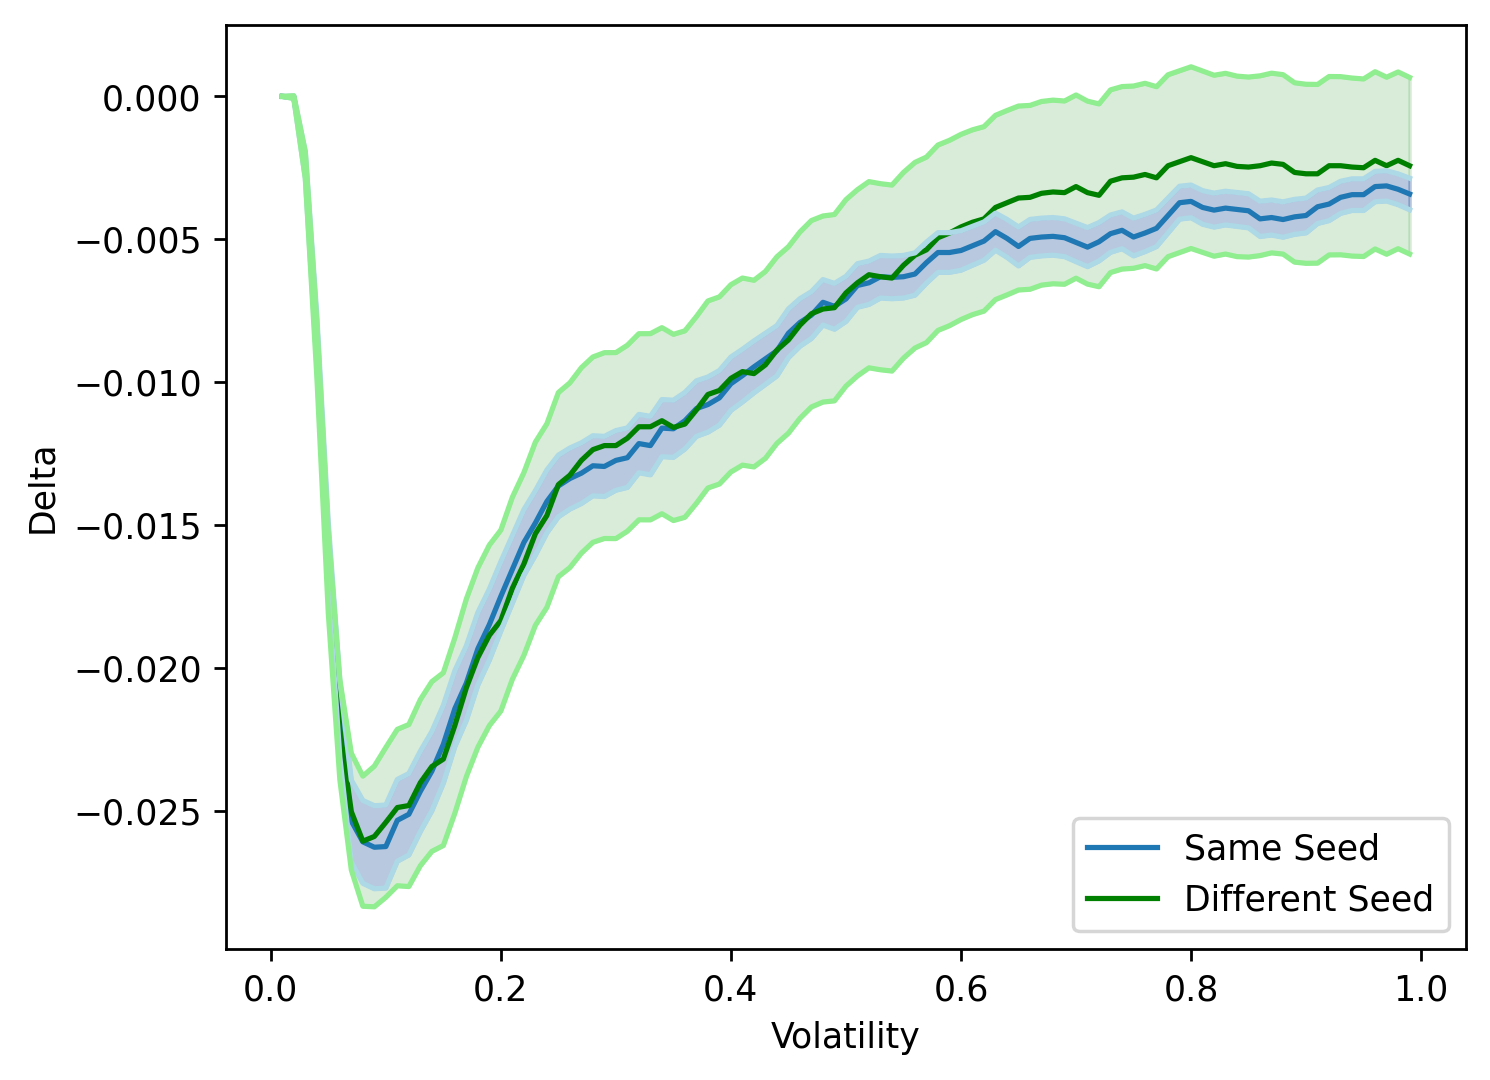

In [47]:
plt.figure(dpi=250)
plt.plot(volatilities, deltas_sameseed_digi, label="Same Seed")
plt.plot(volatilities, delta_DiffSeed_digi, label="Different Seed", color = "green")
plt.plot(volatilities, upper_delta_digi, color = "lightblue")
plt.plot(volatilities, lower_delta_digi, color = "lightblue")
plt.plot(volatilities, upper_diffSeed_digi, color = "lightgreen")
plt.plot(volatilities, lower_diffSeed_digi, color = "lightgreen")
plt.fill_between(volatilities, upper_diffSeed_digi, lower_diffSeed_digi, color="green", alpha=0.15)
plt.fill_between(volatilities, upper_delta_digi, lower_delta_digi, color="blue", alpha=0.15)
plt.legend()
plt.xlabel("Volatility")    
plt.ylabel("Delta")


In [48]:
@njit
def geometricBrownianMotion(S0, r, delta_t, N, sigma):
    """
    Function to simulate the stock price using Geometric Brownian Motion

    Args:
        S0 : Stock price at time 0
        r : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatality of the stock

    Returns:
        stock_prices : Stock prices for N time steps
    """

    stock_prices = np.zeros(N)
    stock_prices[0] = S0
    for i in range(1, N):
        Zm = np.random.normal()
        next_S = stock_prices[i-1] * np.exp((r - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * Zm)
        stock_prices[i] = next_S
        
    return stock_prices

In [49]:
@njit
def OptionPrice_Digital_PathwiseSmooth(S0, r, delta_t, N, sigma, K, M, option_type = "put", epsilon = 0.05):
    """
    Function to price the option using Monte Carlo simulation for Digital Option with smooth payoff

    Args:
        S0 : Stock price at time 0
        r : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatality of the stock
        K : Strike price
        M : Number of simulations
        option_type (str, optional): Type of Option. Defaults to "call".
        seed_value (int, optional): Seed value for random number generation.Defaults to 0.

    Returns:
        price_option : Price of the option at current time
        std_error : Standard error
        ml : Lower bound of the confidence interval
        mu : Upper bound of the confidence interval
    """
    delta = np.zeros(M)
    T  = N * delta_t
    for i in range(M):
        stock_price_N = geometricBrownianMotion(S0, r, delta_t, N, sigma)[-1]
    
        if option_type == "call":
            smooth_payoff = 1 / (1 + np.exp((stock_price_N - K)/epsilon))
            derivative_smooth =  smooth_payoff * (1 - smooth_payoff)/ epsilon
            delta[i] = np.exp(-r*T) * derivative_smooth * (stock_price_N/S0)
        else:
            smooth_payoff = 1 / (1 + np.exp((-stock_price_N + K)/epsilon))
            derivative_smooth =  - smooth_payoff * (1 - smooth_payoff)/ epsilon
            delta[i] = np.exp(-r*T) * derivative_smooth * (stock_price_N/S0)
        
    ml, mu = confidence_interval(delta)
    
    price_option = np.mean(delta)
    std_error = np.std(delta) / np.sqrt(M)
    
    return price_option, std_error, (ml, mu)

In [50]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
M = 20000
volatilities = np.arange(0.01, 1, 0.01)
# Monte Carlo Simulation for Digital Option pricing with smooth payoff  
deltas_smothPath = []
lower_smoothPath = []
upper_smoothPath = []
for sigma in tqdm(volatilities):
    delta_smothPath ,_ , CI_SmoothPath = OptionPrice_Digital_PathwiseSmooth(S0, r, delta_t, N, sigma, K, M,"put")
    deltas_smothPath.append(delta_smothPath)
    lower_smoothPath.append(CI_SmoothPath[0])
    upper_smoothPath.append(CI_SmoothPath[1])

100%|██████████| 99/99 [00:14<00:00,  7.03it/s]


In [51]:
# Delta using likelihood method
def calculate_DeltaDigital(S0, K, r, sigma, T, delta_t, M, option_type = "put"):
    """
    Function to calculate the delta for Digital Option using Pathwise method

    Args:
        S0 : Stock price at time 0
        K : Strike price
        r : Risk free interest rate
        sigma : Volatality of the stock
        T : Maturity time
        M : Number of simulations
        delta_t : Time step
        seed_value (int, optional): Seed value for random number generation.Defaults to 0.

    Returns:
        delta : Delta value
    """
    delta = np.zeros(M)
    for i in range(M):
        S = euler_Method(S0, r, delta_t, int(T/delta_t), sigma)[-1]
        Y = (np.log(S/S0) - (r - 0.5 * sigma**2)*T)/(sigma**2 * T * S0)
        if option_type == "call":
            if S > K:
                delta[i] = np.exp(-r*T) * Y / (S0*sigma*np.sqrt(T))
            else:
                delta[i] = 0
        else:
            if S < K:
                delta[i] = np.exp(-r*T) * Y / (S0*sigma*np.sqrt(T))
            else:
                delta[i] = 0

    return delta.mean(), confidence_interval(delta)

In [52]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
M = 20000
volatilities = np.arange(0.01, 1, 0.01)
delta_likelihood = []
lower_likelihood = []
upper_likelihood = []
# Monte Carlo Simulation for Digital Option pricing with likelihood method
for sigma in tqdm(volatilities):
    delta_likeli, CI_likeli = calculate_DeltaDigital(S0, K, r, sigma, T, delta_t, M)
    delta_likelihood.append(delta_likeli)
    lower_likelihood.append(CI_likeli[0])
    upper_likelihood.append(CI_likeli[1])

100%|██████████| 99/99 [00:08<00:00, 11.66it/s]


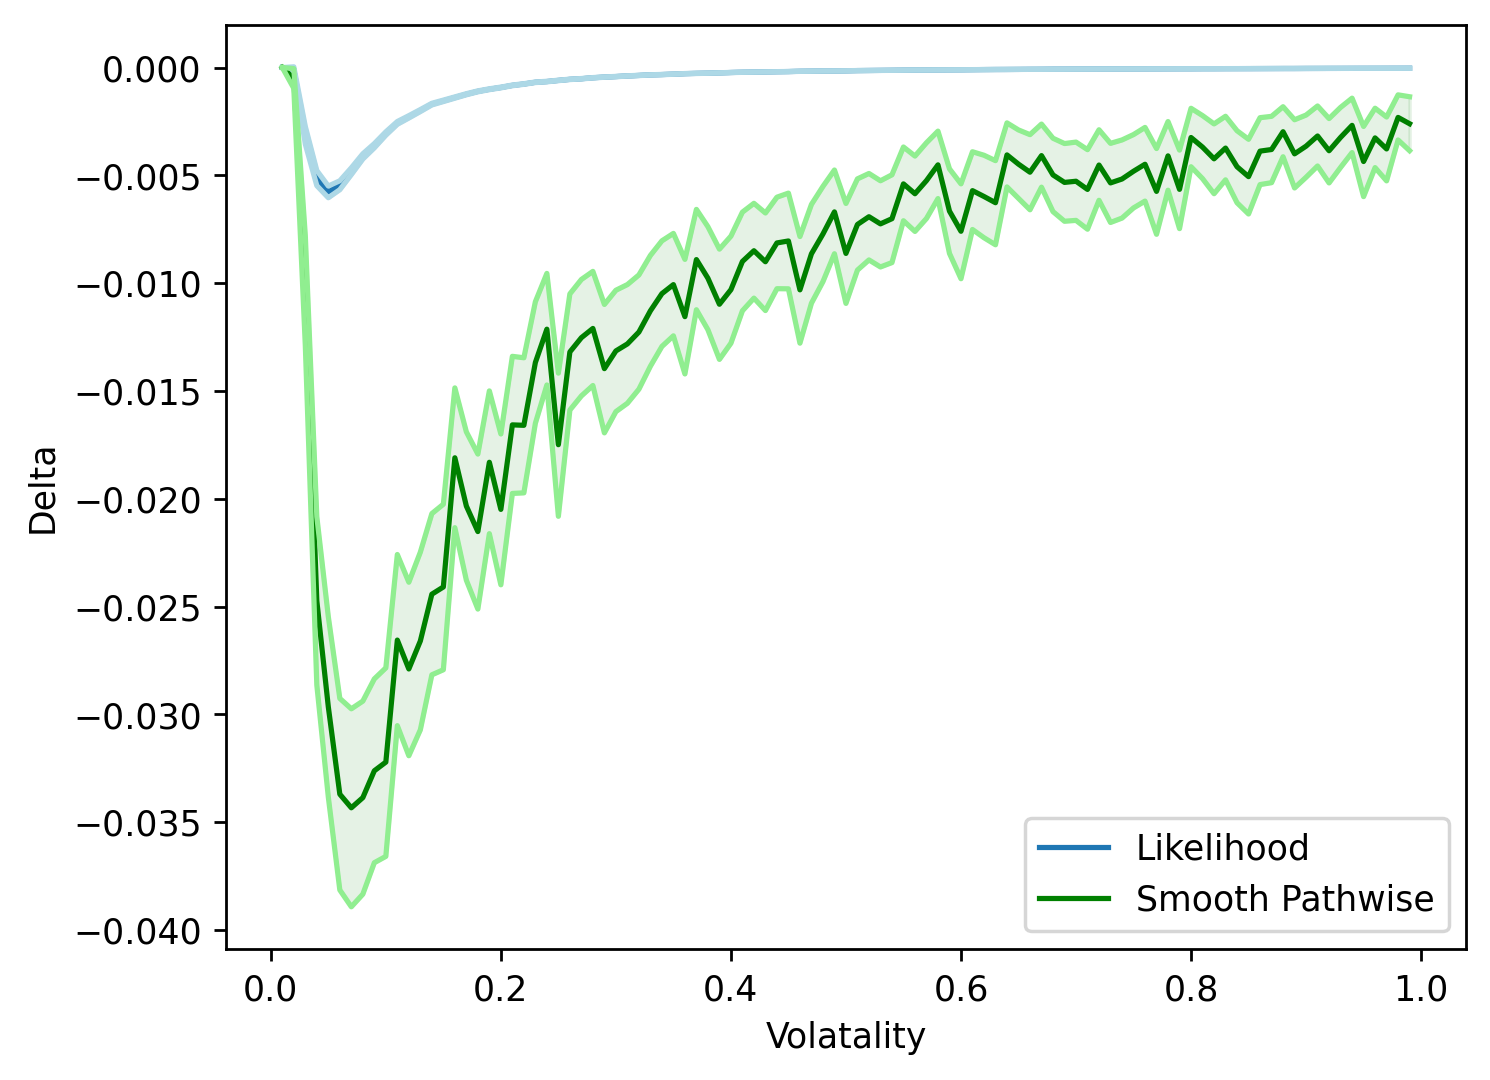

In [53]:
plt.figure(dpi=250)
plt.plot(volatilities, delta_likelihood, label="Likelihood")
plt.plot(volatilities, upper_likelihood, color = "lightblue")
plt.plot(volatilities, lower_likelihood, color = "lightblue")
plt.fill_between(volatilities, upper_likelihood, lower_likelihood, color="k", alpha=0.1)
plt.plot(volatilities, deltas_smothPath, color = "green",label="Smooth Pathwise")
plt.plot(volatilities, upper_smoothPath, color = "lightgreen")
plt.plot(volatilities, lower_smoothPath, color = "lightgreen")
plt.fill_between(volatilities, upper_smoothPath, lower_smoothPath, color="green", alpha=0.1)

plt.xlabel("Volatality")
plt.ylabel("Delta")
plt.legend()

In [54]:
T = 1.0
K = 99
r = 0.06
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
M = 20000
S0_values = np.arange(50, 150, 0.5)
deltas_S0 = []
lowerS0 = []
upperS0 = []
deltaS0_path = []
lowerS0_path = []
upperS0_path = []

for S0 in tqdm(S0_values):
    delta_S0, CI_S0 = calculate_DeltaDigital(S0, K, r, sigma, T, delta_t, M, "put")
    deltaS02, _, CI_S02 = OptionPrice_Digital_PathwiseSmooth(S0, r, delta_t, N, sigma, K, M, "put")
    deltas_S0.append(delta_S0)
    lowerS0.append(CI_S0[0])
    upperS0.append(CI_S0[1])
    deltaS0_path.append(deltaS02)
    lowerS0_path.append(CI_S02[0])
    upperS0_path.append(CI_S02[1])

100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


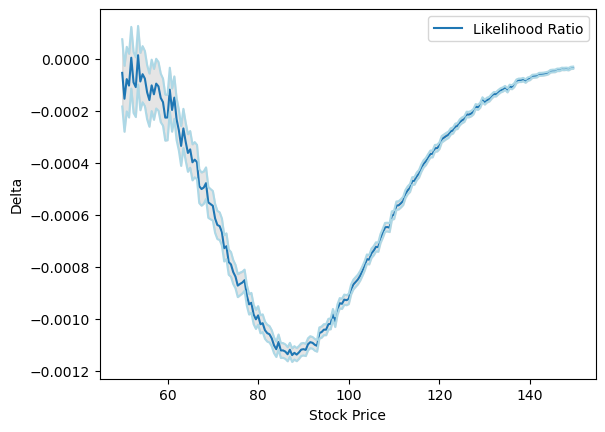

In [55]:
plt.plot(S0_values, deltas_S0, label="Likelihood Ratio")
plt.plot(S0_values, upperS0, color = "lightblue")
plt.plot(S0_values, lowerS0, color = "lightblue")
plt.fill_between(S0_values, upperS0, lowerS0, color="k", alpha=0.1)
plt.xlabel("Stock Price")
plt.ylabel("Delta")
plt.legend()


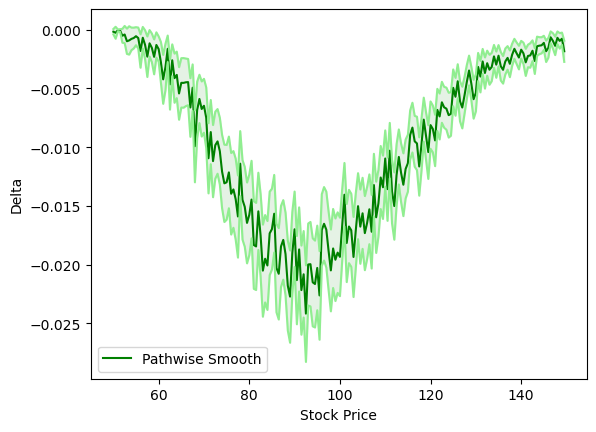

In [56]:
plt.plot(S0_values, deltaS0_path, color = "green",label="Pathwise Smooth")
plt.plot(S0_values, upperS0_path, color = "lightgreen")
plt.plot(S0_values, lowerS0_path, color = "lightgreen")
plt.fill_between(S0_values, upperS0_path, lowerS0_path, color="green", alpha=0.1)
plt.xlabel("Stock Price")
plt.ylabel("Delta")
plt.legend()

## Variance Reduction

In [57]:
def calculateAsianOptionPrice_Analytical(riskfree_rate, S0, StrikeP, T, N, vol_stockP, option_type = "call"):
    """
    Function to calculate the price of the Asian Option using analytical method
    Args:
        riskfree_rate : risk free rate
        Current_S : Current stock price
        T : Maturity time
        N : Number of times the stock price is observed
        vol_stockP : Volatility of the stock price
        option_type : Type of option (call/put)
    
    Returns:
        option_price : Option price
    """
    sigma_tilda = sigma * np.sqrt((2*N + 1)/(6*(N + 1)))
    r_tilda = 0.5 * ((r - 0.5 * sigma **2) + sigma_tilda **2)
    d1 = (np.log(S0/K) + (r_tilda + 0.5 * sigma_tilda **2) * T)/(sigma_tilda * np.sqrt(T))
    d2 = (np.log(S0/K) + (r_tilda - 0.5 * sigma_tilda **2) * T)/(sigma_tilda * np.sqrt(T))
    
    if option_type == "call":
        optionValue = np.exp(-riskfree_rate * T) * (S0 * np.exp(r_tilda * T) * norm.cdf(d1) - K * norm.cdf(d2))
    else:
        pass
    return optionValue
    


In [58]:
@njit
def calculateAsianOptionPrice_MonteCarlo(riskfree_rate, Current_S, StrikeP, delta_t, T, vol_stockP, M, option_type = "call"):
    """
    Function to calculate the Asian option price using Monte Carlo method
    
    Args:
        riskfree_rate : risk free rate
        Current_S : Current stock price
        T : Maturity time
        N : Number of times the stock price is observed
        vol_stockP : Volatility of the stock price
        M : Number of simulations
        option_type : Type of option (call/put)
    
    Returns:
        option_price : Option price
    """
    N = int(T/delta_t)
    payOffs = np.zeros(M)
    for i in range(M):
        stockPrices = euler_Method(Current_S, riskfree_rate, delta_t, N, vol_stockP)
        averagePrice = np.exp(np.average(np.log(stockPrices)))
        if option_type == "call":
            payOffs[i] = max(averagePrice - StrikeP, 0)
        else:
            payOffs[i]= max(StrikeP - averagePrice, 0)
    lower , upper = confidence_interval(payOffs * np.exp(-riskfree_rate * T))
    optionValue = np.exp(-riskfree_rate * T) * np.mean(payOffs)
    
    std_error = np.std(payOffs) / np.sqrt(M)
    
    return optionValue, lower, upper, std_error

In [59]:
r = 0.06           # risk free rate
dt = 1/252          # time step
S0 = 100             # initial stock price
T = 1.0             # time to maturity
sigma = 0.2         # volatility
K = 99             # strike price
Analytical_AsianOption_price = calculateAsianOptionPrice_Analytical(r, S0, K, T, N, sigma)
MonteCarlo_AsianOption_price, ml, mu, _ = calculateAsianOptionPrice_MonteCarlo(r, S0, K, dt, T, sigma, 20000)
print("Analytical Asian Option Price: ", Analytical_AsianOption_price)
print("Monte Carlo Asian Option Price: ", MonteCarlo_AsianOption_price, ml, mu)

Analytical Asian Option Price:  6.3303060633628
Monte Carlo Asian Option Price:  6.278707125902562 6.1687252790248674 6.388688972780239


In [60]:
no_of_simulations = np.arange(100, 10000, 50)  # Number of simulations
MC_Asian_Option_prices = []                     # Monte Carlo Asian Option Prices
lower_bounds_Asian = []                         # Lower bounds of the confidence interval   
upper_bounds_Asian = []                         # Upper bounds of the confidence interval
std_error_AsianMC = []                            # Standard error
# Monte Carlo Simulation for Asian Option Pricing
for sim in tqdm(no_of_simulations):
    MonteCarlo_AsianOption_price, ml, mu, stdError = calculateAsianOptionPrice_MonteCarlo(r, S0, K, dt, T, sigma, sim)
    MC_Asian_Option_prices.append(MonteCarlo_AsianOption_price)
    lower_bounds_Asian.append(ml)   
    upper_bounds_Asian.append(mu) 
    std_error_AsianMC.append(stdError)

100%|██████████| 198/198 [00:03<00:00, 55.14it/s]


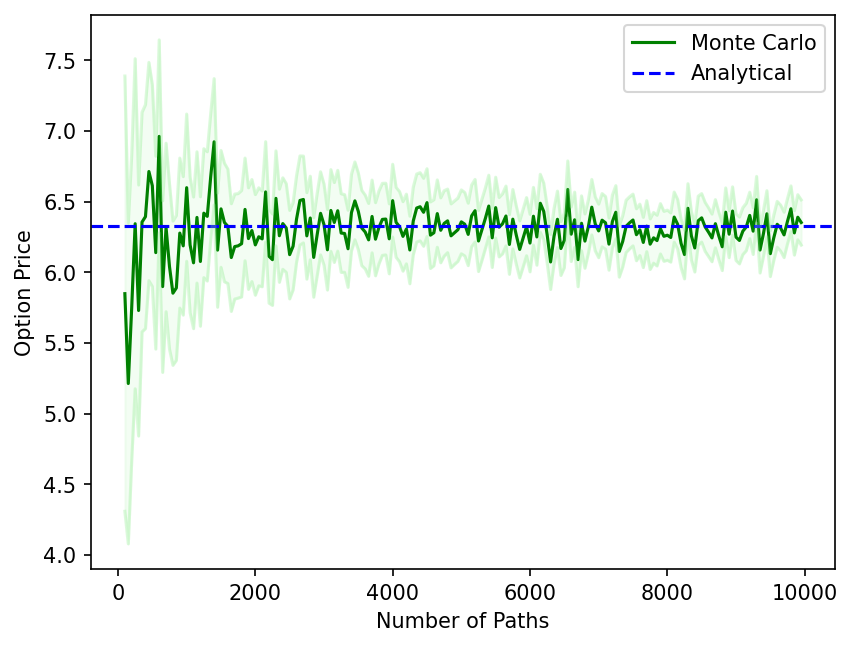

In [61]:
# Plotting the Monte Carlo Asian Option Prices
plt.figure(dpi=150)
plt.plot(no_of_simulations, MC_Asian_Option_prices, label = "Monte Carlo", color = "green")
plt.axhline(Analytical_AsianOption_price, linestyle = "--", color = "b", label = "Analytical")
plt.plot(no_of_simulations, upper_bounds_Asian, color = "lightgreen", alpha=0.3)
plt.plot(no_of_simulations, lower_bounds_Asian, color = "lightgreen", alpha=0.3)
plt.fill_between(no_of_simulations, upper_bounds_Asian, lower_bounds_Asian, color="lightgreen", alpha=0.1)   
plt.xlabel("Number of Paths")
plt.ylabel("Option Price")
plt.legend()
plt.show()

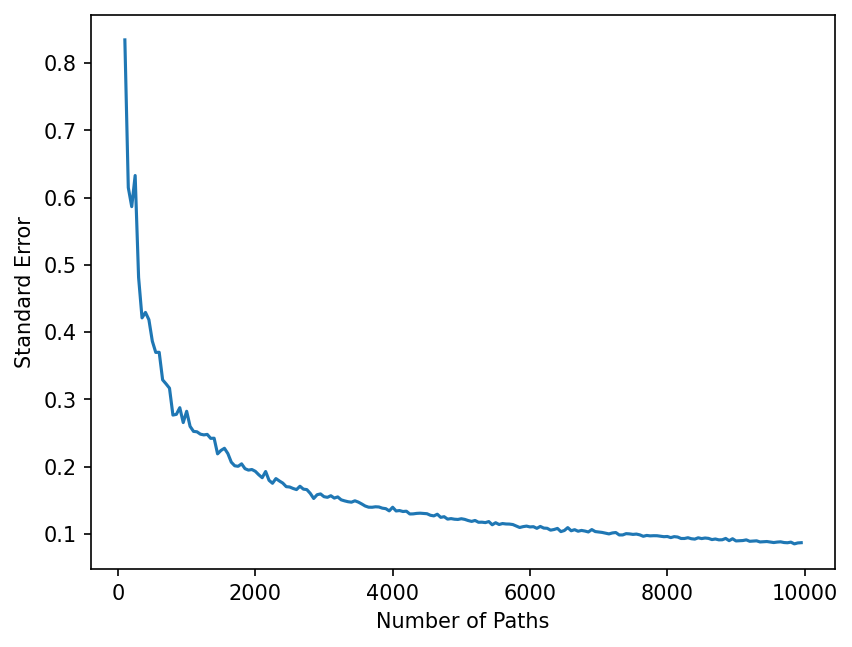

In [62]:
plt.figure(dpi=150)
plt.plot(no_of_simulations, std_error_AsianMC)
plt.xlabel("Number of Paths")
plt.ylabel("Standard Error")
plt.savefig("StandardError_AsianOption.png")
plt.show()


### Control Variate

In [138]:
@njit
def asianOption_ArithmeticMC(S0, r, vol, K, T, N, M, num_timePoints, option_type = "call"):
    """
    Function to calculate the price of the Asian option  based on Arithmetic Averages using Monte Carlo method

    Args:
        S0 : Current stock price
        r : Risk free interest rate
        vol : Volatility of the stock Price
        K : Strike price
        T : Maturity time
        N : Number of times the stock price is observed
        M : Number of simulations
        num_timePoints : Number of time points in average
        option_type : Type of option (call/put)
    """
    dt = T/N
    payoff = np.zeros(M)
    for i in range(M):
        stockPrices = geometricBrownianMotion(S0, r, dt, N, vol)
        averagePrice = np.mean(stockPrices[:num_timePoints])
        if option_type == "call":
            payoff[i] = np.maximum(averagePrice - K, 0)
        else:
            payoff[i] = np.maximum(K - averagePrice, 0)
    price = np.exp(-r * T) * np.mean(payoff)
    std_error = np.std(payoff) / np.sqrt(M)
    lower, upper = confidence_interval(payoff * np.exp(-r * T))
    return price, (lower, upper), std_error
    

In [124]:
optionPrice_AMC = []     # Monte Carlo Asian Option Prices for Arithmetic Averages
CI_lower_AM = []
CI_upper_AM = []
std_error_AM = []       # Standard error for Monte Carlo Asian Option Prices in Arithmetic Averages
#### Parameters
r = 0.06           # risk free rate
dt = 1/252          # time step
S0 = 100             # initial stock price
T = 1.0             # time to maturity
sigma = 0.2         # volatility
K = 99             # strike price
m = np.arange(100, 10000, 50)
for M in tqdm(m):
    x, y, z = asianOption_ArithmeticMC(S0, r, sigma, K, T, N, M, 252, "call")
    optionPrice_AMC.append(x)
    CI_lower_AM.append(y[0])
    CI_upper_AM.append(y[1])
    std_error_AM.append(z)
    

100%|██████████| 198/198 [00:07<00:00, 28.11it/s]


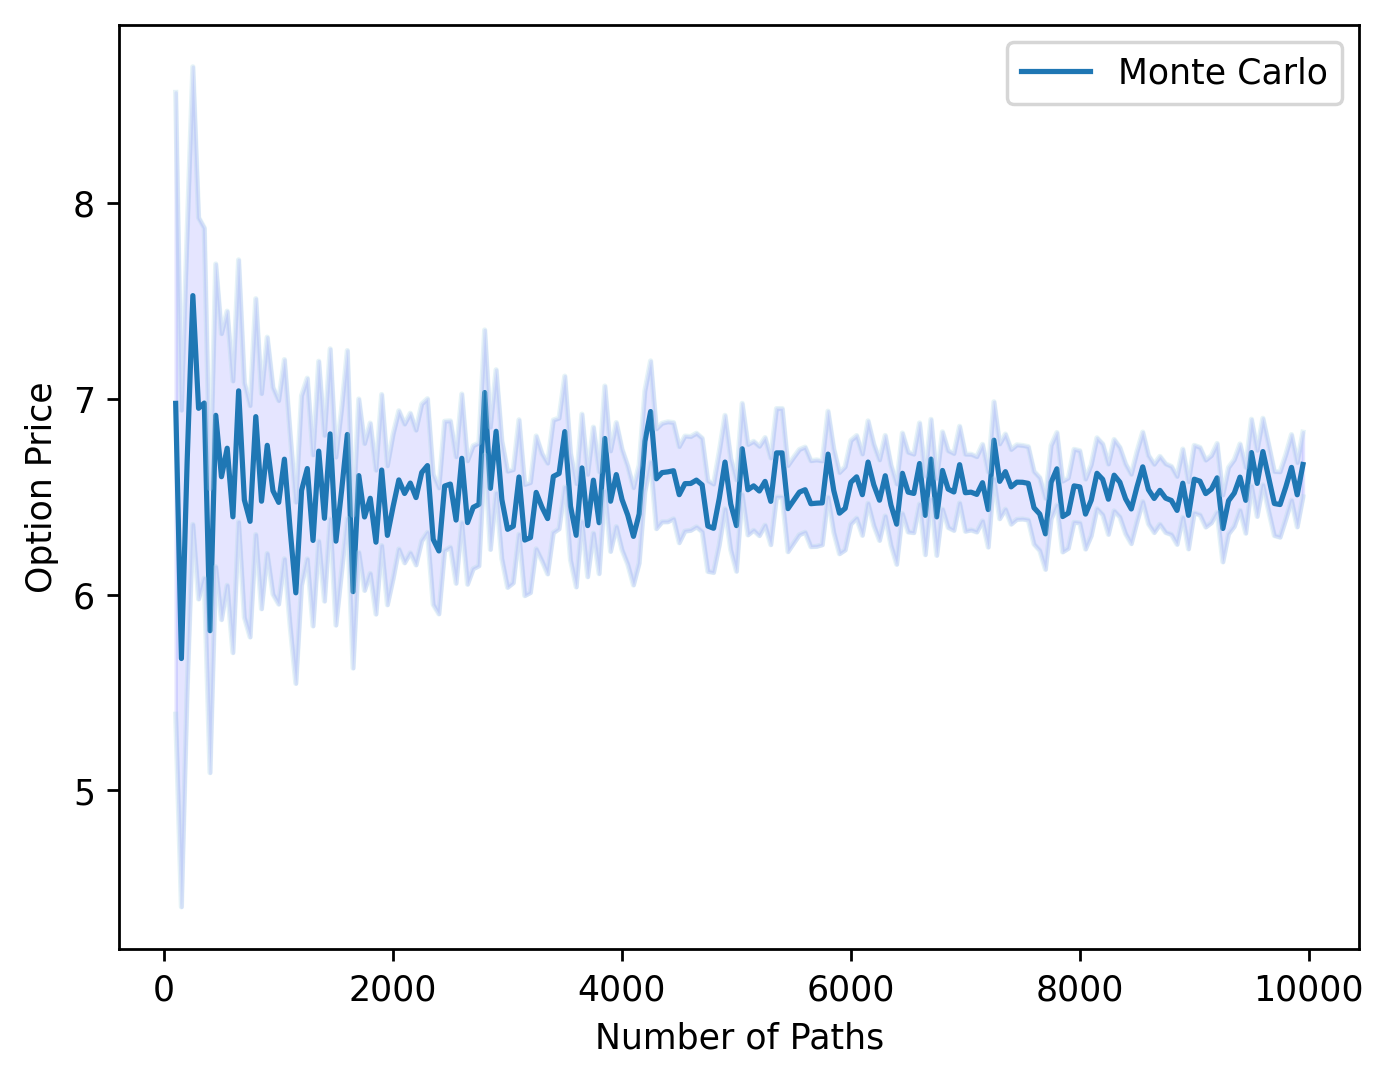

In [125]:
plt.figure(dpi=250)
plt.plot(m, optionPrice_AMC, label = "Monte Carlo")
plt.plot(m, CI_upper_AM, color = "lightblue", alpha=0.3)
plt.plot(m, CI_lower_AM, color = "lightblue", alpha=0.3)
plt.fill_between(m, CI_upper_AM, CI_lower_AM, color="blue", alpha=0.1)
plt.xlabel("Number of Paths")
plt.ylabel("Option Price")
plt.legend()

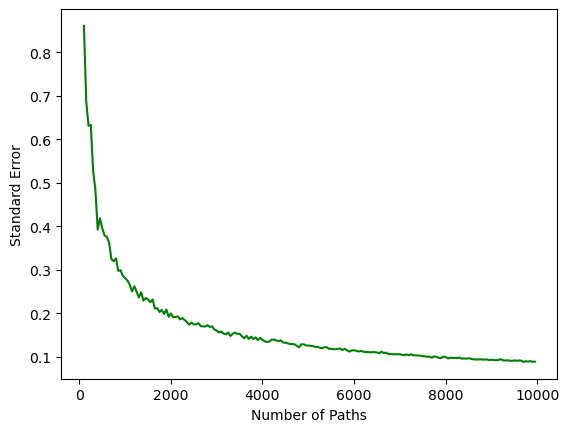

In [126]:
plt.plot(m, std_error_AM, label = "Monte Carlo", color = "green")
plt.xlabel("Number of Paths")
plt.ylabel("Standard Error")
plt.show()

In [145]:

def function_G(stock_prices, strike_price, r, T):
    """
    Function to calculate the payoff for the lookback option
    
    Args:
        stock_prices : Stock prices
        strike_price : Strike price
    
    Returns:
        H : Payoff
    """
    geometric_mean = np.exp(np.log(stock_prices).mean())

    G = np.maximum(geometric_mean - strike_price, 0)
    
    return G

In [146]:

def expected_G(r, sigma, S0, K, T, N):
    
    sigma_tilda = sigma * np.sqrt((2*N + 1)/(6*(N + 1)))
    r_tilda = 0.5 * ((r - 0.5 * sigma **2) + sigma_tilda **2)
    d1 = (np.log(S0/K) + (r_tilda + 0.5 * sigma_tilda **2) * T)/(sigma_tilda * np.sqrt(T))
    d2 = (np.log(S0/K) + (r_tilda - 0.5 * sigma_tilda **2) * T)/(sigma_tilda * np.sqrt(T))
    
    expected_H = S0 * np.exp(r_tilda * T) * norm.cdf(d1) - K * norm.cdf(d2)    
    
    return expected_H * np.exp(-r * T)

In [147]:

def calculateAsianOptionPrice_ControlVariate(riskfree_rate, S0, StrikeP, delta_t, T, vol_stockP, M, option_type = "call"):
    """
    Function to calculate the Asian option price using Monte Carlo method
    
    Args:
        riskfree_rate : risk free rate
        Current_S : Current stock price
        T : Maturity time
        N : Number of times the stock price is observed
        vol_stockP : Volatility of the stock price
        M : Number of simulations
        option_type : Type of option (call/put)
    
    Returns:
        option_price : Option price
    """
    N = int(T/delta_t)
    payOffs = np.zeros(M)
    g_y = np.zeros(M)
    expected_Gy = np.zeros(M)
    
    for i in range(M):
        stockPrices = euler_Method(S0, riskfree_rate, delta_t, N, vol_stockP)
        averagePrice = np.mean(stockPrices)
        g_y[i] = function_G(stockPrices, StrikeP, riskfree_rate, T)
        expected_Gy[i] = expected_G(riskfree_rate, vol_stockP, S0, StrikeP, T, N)
        
        if option_type == "call":
            payOffs[i] = np.maximum(averagePrice - StrikeP, 0)
        else:
            payOffs[i]= np.maximum(StrikeP - averagePrice, 0) 
            
    covariance = np.cov(g_y, payOffs)[0, 1]
    var_g_y = np.var(g_y)  
    lambda1 = covariance/var_g_y
    
    Z = payOffs + lambda1 * (expected_Gy - g_y)
    std_error = np.std(Z) / np.sqrt(M)
    
    return np.mean(Z) , confidence_interval(Z), std_error

In [148]:
optionPrice_control = []
CI_lower_control = []
CI_upper_control = []
std_error_control = []

#### Parameters
r = 0.06           # risk free rate
dt = 1/252          # time step
S0 = 100             # initial stock price
T = 1.0             # time to maturity
sigma = 0.2         # volatility
K = 99             # strike price

m = np.arange(100, 20000, 100)
for M in tqdm(m):
    x, y, z = calculateAsianOptionPrice_ControlVariate(r, S0, K, dt, T, sigma, M)
    optionPrice_control.append(x)
    CI_lower_control.append(y[0])
    CI_upper_control.append(y[1])
    std_error_control.append(z)
    

100%|██████████| 199/199 [02:04<00:00,  1.60it/s]


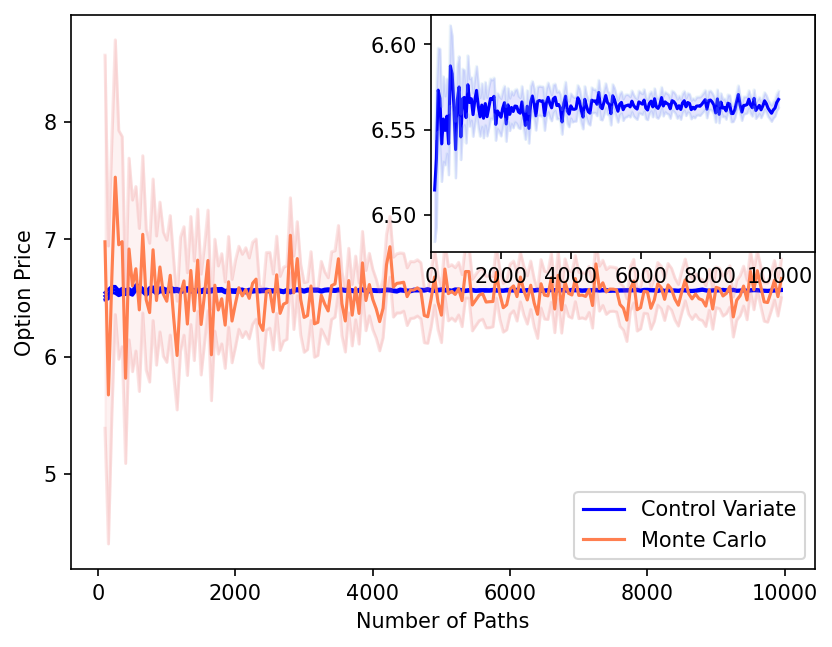

In [131]:
plt.figure(dpi=150)
plt.plot(m, optionPrice_control, label = "Control Variate", color = "blue")
plt.plot(m, CI_upper_control, "blue")
plt.plot(m, CI_lower_control, "blue")
plt.fill_between(m, CI_upper_control, CI_lower_control, color="b", alpha=0.15)
plt.plot(m, optionPrice_AMC, label = "Monte Carlo", color = 'coral')
plt.plot(m, CI_upper_AM, color = "lightcoral", alpha=0.2)
plt.plot(m, CI_lower_AM, color = "lightcoral", alpha=0.2)
plt.fill_between(m, CI_upper_AM, CI_lower_AM, color="lightcoral", alpha=0.1)
plt.xlabel("Number of Paths")
plt.ylabel("Option Price")
plt.legend(loc='lower right')
# Add a zoomed-in plot
left, bottom, width, height = [0.5, 0.55, 0.40, 0.33] # Adjust these values to position your zoom plot
ax_zoom = plt.gcf().add_axes([left, bottom, width, height])
ax_zoom.plot(m, optionPrice_control, label = "Control Variate", color = "blue")
ax_zoom.plot(m, CI_upper_control, "lightblue", alpha=0.2)
ax_zoom.plot(m, CI_lower_control, "lightblue", alpha=0.2)
ax_zoom.fill_between(m, CI_upper_control, CI_lower_control, color="blue", alpha=0.10)
ax_zoom.set_xlim(0, 11000)  # Adjust the limits for the zoomed-in region
plt.savefig("ControlVariate_AsianOption.png")
plt.show()

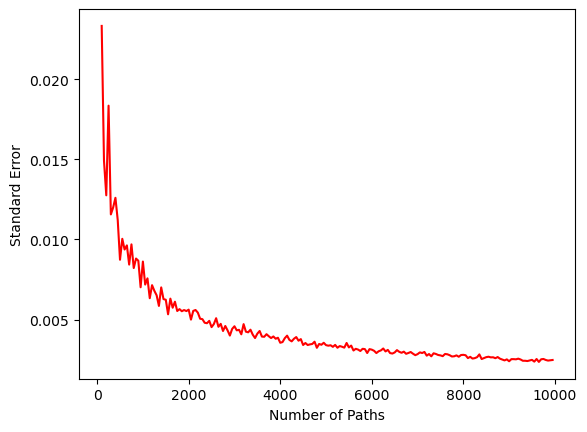

In [72]:
plt.figure(dpi=100)
plt.plot(m, std_error_control, label = "Control Variate", color = "red")
plt.xlabel("Number of Paths")
plt.ylabel("Standard Error")
plt.show()

In [73]:
optionPrice_controlS0 = []
CI_lower_controlS0 = []
CI_upper_controlSO = []
std_error_controlS0 = []
optionPrice_MCS0 = []
CI_lower_MCS0 = []
CI_upper_MCSO = []
std_error_MCS0 = []

#### Parameters
r = 0.06           # risk free rate
dt = 1/252          # time step
S0 = 100             # initial stock price
T = 1.0             # time to maturity
sigma = 0.2         # volatility
M = 6000
K_values = np.arange(60, 120, 1)
for K in tqdm(K_values):
    x2, y2, z2 = calculateAsianOptionPrice_ControlVariate(r, S0, K, dt, T, sigma, M)
    x3, y3, z3 = asianOption_ArithmeticMC(S0, r, sigma, K, T, N, M, 252, "call")
    optionPrice_controlS0.append(x2)
    CI_lower_controlS0.append(y2[0])
    CI_upper_controlSO.append(y2[1])
    std_error_controlS0.append(z2)
    optionPrice_MCS0.append(x3)
    CI_lower_MCS0.append(y3[0])
    CI_upper_MCSO.append(y3[1])
    std_error_MCS0.append(z3)

100%|██████████| 60/60 [00:27<00:00,  2.21it/s]


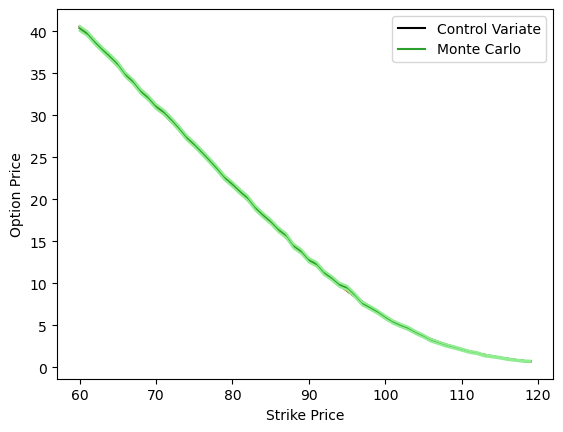

In [74]:
plt.plot(K_values, optionPrice_controlS0, label = "Control Variate", color = "black")
plt.plot(K_values, CI_upper_controlSO)
plt.plot(K_values, CI_lower_controlS0)
plt.fill_between(K_values, CI_upper_controlSO, CI_lower_controlS0, color="blue", alpha=0.15)
plt.plot(K_values, optionPrice_MCS0, label = "Monte Carlo")
plt.plot(K_values, CI_upper_MCSO, color = "lightgreen")
plt.plot(K_values, CI_lower_MCS0, color = "lightgreen")
plt.fill_between(K_values, CI_upper_MCSO, CI_lower_MCS0, color="blue", alpha=0.1)
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.legend()

(60.0, 120.0)

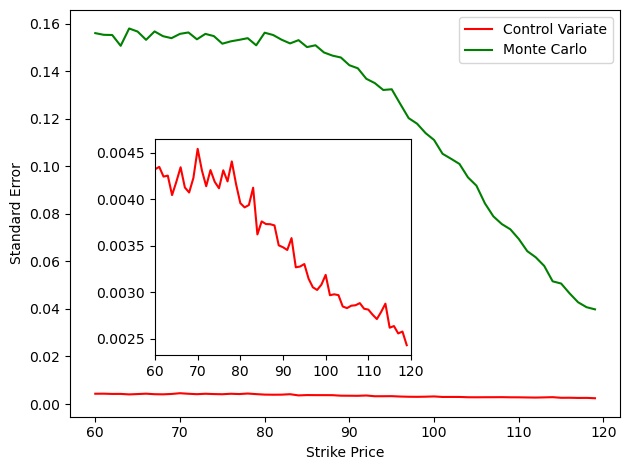

In [75]:
plt.figure(dpi=100)
plt.plot(K_values, std_error_controlS0, label = "Control Variate", color = "red")
plt.plot(K_values, std_error_MCS0, label = "Monte Carlo", color = "green")
plt.xlabel("Strike Price")
plt.ylabel("Standard Error")
plt.tight_layout()
plt.legend()
# Add a zoomed-in plot
left, bottom, width, height = [0.25, 0.25, 0.4, 0.45] # Adjust these values to position your zoom plot
ax_zoom = plt.gcf().add_axes([left, bottom, width, height])
ax_zoom.plot(K_values, std_error_controlS0, "red")
ax_zoom.set_xlim(60, 120)  # Adjust the limits for the zoomed-in region